# Cleaning Listing Data

#### Reading the listing data 

In [1]:
#import all packages needed 
import pandas as pd
import numpy as np 
import re
from datetime import datetime 

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Data/2. airbnb_data/Rome/Rome all listings detailed/Rome Q1 detailed listings.xlsx'
#read data, and quickly check if it is correctly read in
dataframe1= pd.read_excel(file_path)

In [2]:
dataframe1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24924 entries, 0 to 24923
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            24924 non-null  int64         
 1   listing_url                                   24924 non-null  object        
 2   scrape_id                                     24924 non-null  int64         
 3   last_scraped                                  24924 non-null  datetime64[ns]
 4   source                                        24924 non-null  object        
 5   name                                          24920 non-null  object        
 6   description                                   24465 non-null  object        
 7   neighborhood_overview                         15266 non-null  object        
 8   picture_url                                   24924 non-null  obje

#### Cleaning process 

In [3]:
#decided which columns will not be relevant for the first initial analysis
columns_to_drop =["name","description","host_location","host_thumbnail_url","host_name","bathrooms","first_review","last_review"
                  ,"listing_url","scrape_id","last_scraped", "host_picture_url","host_url", "host_has_profile_pic", 
                  "host_verifications","source","calendar_last_scraped","license","picture_url","host_about",
                             "neighbourhood","neighbourhood_group_cleansed","minimum_minimum_nights",
                             "maximum_minimum_nights","minimum_maximum_nights","maximum_maximum_nights",
                             "minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated",
                             "neighborhood_overview","host_neighbourhood", "host_acceptance_rate", "host_since",
                  "minimum_nights","maximum_nights","has_availability"]
dataframe1 = dataframe1.drop(columns_to_drop, axis=1)

#solving trailing white space problem
string_columns = dataframe1.select_dtypes(include='object').columns.tolist()
for i in string_columns:
    dataframe1[i] = dataframe1[i].str.strip()

#missing values have always been checked during this cleaning with the function: print(dataframe1.isnull().mean()) 

#host_response_time, filling in the empty ones with "unknown"
dataframe1.host_response_time.fillna("unknown", inplace=True)
dataframe1.host_response_time.value_counts(normalize=True)

#adapting the host_response_rate column to better fit
# Removing the % sign from the host_response_rate string and converting to an integer
dataframe1.host_response_rate = dataframe1.host_response_rate.str[:-1].astype('float64')
# Bin into four categories
dataframe1.host_response_rate = pd.cut(dataframe1.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)
# Converting to string
dataframe1.host_response_rate = dataframe1.host_response_rate.astype('str')
# Replace nulls with 'unknown'
dataframe1.host_response_rate.replace('nan', 'unknown', inplace=True)

#these rows do not have that big of a missing value amount so we just delete the missing value rows here
col = ["host_identity_verified","host_listings_count","host_total_listings_count","host_is_superhost"]
for column in col:
    dataframe1.dropna(subset=[column], inplace=True)

# Category counts
dataframe1.host_response_rate.value_counts()
#fill out all NaN within string columns with ''
for column in string_columns:
    dataframe1[column] = dataframe1[column].fillna("")   

#fixing the "bathroom_text" column to only numbers and renaming it
def extract_numeric(value):
    numeric_part = re.search(r'\d+\.\d+|\d+', str(value))
    return float(numeric_part.group()) if numeric_part else None
dataframe1['bathrooms_text'] = dataframe1['bathrooms_text'].apply(extract_numeric)
dataframe1.rename(columns={'bathrooms_text': 'bathrooms'}, inplace=True)

#dropping those that still have no bathroom amount 
dataframe1.dropna(subset=["bathrooms"], inplace=True)
    
#delete those that have no information about both beds and bedrooms
dataframe1.dropna(subset=['beds', 'bedrooms'], how='all', inplace=True)

#dropping those with +4 bedrooms (outliers) and no information about bedroom and between 1-4 beds is a studio so 0 bedrooms
dataframe1.loc[(dataframe1['bedrooms'].isnull()) & (dataframe1['beds'].between(1, 4)), 'bedrooms'] = 0
dataframe1.drop(dataframe1[(dataframe1['bedrooms'].isnull()) & (dataframe1['beds'] > 4)].index, inplace=True)

#fill in all the other empty values with the amount of bedrooms 
dataframe1['beds'].fillna(dataframe1['bedrooms'], inplace=True)

#dropping those that still have no bedroom amount 
dataframe1.dropna(subset=["bedrooms"], inplace=True)

#Simplifying the property_types in to 4 categories
dataframe1.property_type.replace({
    'Barn': 'House',
    'Boat': 'Other',
    'Bus': 'Other',
    'Camper/RV': 'Other',
    'Casa particular': 'House',
    'Cave': 'Other',
    'Dome': 'Other',
    'Earthen home': 'House',
    'Entire bed and breakfast': 'Hotel',    
    'Entire bungalow': 'House',
    'Entire condo': 'Apartmen',
    'Entire guesthouse': 'House',
    'Entire home': 'House',
    'Entire guest suite': 'Apartment',
    'Entire rental unit': 'Apartment',
    'Entire loft': 'Apartment',
    'Entire home/apt': 'House',
    'Entire place': 'House',
    'Entire serviced apartment': 'Apartment',
    'Entire townhouse': 'House',
    'Entire villa': 'House',
    'Entire vacation home': 'House',
    'Floor': 'Other',
    'Houseboat': 'Other',
    'Private room': 'Apartment',
    'Island': 'Other',
    'Private room in bed and breakfast': 'Hotel',    
    'Private room in boat': 'Other',
    'Private room in casa particular': 'House',
    'Private room in condo': 'Apartment',
    'Private room in guest suite': 'Apartment',
    'Private room in earthen home': 'House',
    'Private room in home': 'House',
    'Private room in guesthouse': 'House',
    'Private room in loft': 'Apartment',
    'Private room in hostel': 'Hotel',
    'Private room in rental unit': 'Apartment',
    'Private room in townhouse': 'House',
    'Private room in tiny home': 'House',
    'Private room in serviced apartment': 'Apartment',
    'Room in bed and breakfast': 'Hotel',
    'Private room in villa': 'House',
    'Room in serviced apartment': 'Apartment',
    'Room in boutique hotel': 'Hotel',
    'Room in hotel': 'Hotel',
    'Room in hostel': 'Hotel',
    'Shared room in bed and breakfast': 'Hotel',
    'Shared room in boutique hotel': 'Hotel',
    'Shared room in cabin': 'Other',
    'Shared room in boat': 'Other',
    'Shared room in condo': 'Apartment',
    'Shared room in farm stay': 'Other',
    'Shared room in guesthouse': 'House',
    'Shared room in casa particular': 'House',
    'Shared room in ice dome': 'Other',
    'Shared room in home': 'House',
    'Shared room in hostel': 'Hotel',
    'Shared room in hotel': 'Hotel',
    'Shared room in rental unit': 'Apartment',
    'Tiny home': 'House',
    'Shared room in loft': 'Apartment',
    'Shared room in townhouse': 'House',
    'Shared room in tiny home': 'House',
    }, inplace=True)

# Replacing other categories with 'other'
dataframe1.loc[~dataframe1.property_type.isin(['House', 'Apartment','Hotel']), 'property_type'] = 'Other'
#dataframe1['property_type'].value_counts()

#changing the name from neighbourhoud_cleansed to neighbourhood
dataframe1.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace=True)

#convert the necessary columns to a boolean type, which is easier to use
columns_to_convert = ['host_is_superhost', 'instant_bookable', 'host_identity_verified'] 
for column in columns_to_convert:
    dataframe1[column] = dataframe1[column].replace({'f': False, 't': True}).astype(bool)

In [4]:
dataframe1.info()
print(dataframe1.isnull().mean())

<class 'pandas.core.frame.DataFrame'>
Index: 24775 entries, 0 to 24923
Data columns (total 39 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            24775 non-null  int64  
 1   host_id                                       24775 non-null  int64  
 2   host_response_time                            24775 non-null  object 
 3   host_response_rate                            24775 non-null  object 
 4   host_is_superhost                             24775 non-null  bool   
 5   host_listings_count                           24775 non-null  float64
 6   host_total_listings_count                     24775 non-null  float64
 7   host_identity_verified                        24775 non-null  bool   
 8   neighbourhood                                 24775 non-null  object 
 9   latitude                                      24775 non-null  floa

#### Seperating amenities column into seperate boolean columns + total_amenities column

In [5]:
# Convert the string representation of lists to actual lists
import ast
dataframe1["amenities"] = dataframe1["amenities"].apply(ast.literal_eval)

In [6]:
#making a unique list out of all the different kind of amenities that there are
unique_items_set = set.union(*dataframe1["amenities"].apply(set))
print(unique_items_set)
print(len(unique_items_set)) 
#the one that is shown here is taken after the adjustments you can see below

{'Hi-Fun Bluetooth sound system', 'Philips  sound system', 'Free parking on premises – 15 spaces', 'Wifi – 44 Mbps', 'TV with DVD player', '45" HDTV with standard cable, Amazon Prime Video, Apple TV, Chromecast, Disney+, Fire TV, HBO Max, Hulu, Netflix, premium cable, Roku, DVD player', 'Lavanda body soap', 'Wifi – 9 Mbps', '42" HDTV with Amazon Prime Video, Apple TV, Netflix', 'Kenmore stainless steel gas stove', '50" HDTV with Amazon Prime Video, Apple TV, Chromecast, Disney+, Netflix, standard cable', 'HDTV with standard cable, Chromecast', 'Fast wifi – 329 Mbps', '32" HDTV with Amazon Prime Video, Apple TV, Chromecast, Disney+, Fire TV, HBO Max, Hulu, Netflix, premium cable, Roku, standard cable', 'In the common area. refrigerator', '43" HDTV with Fire TV, Netflix, standard cable', 'Anja body soap', 'Shared hot tub - available all year, open 24 hours', 'Herbal Hessences, Panthene shampoo', 'Beko induction stove', 'Dryer – In building', 'Fast wifi – 414 Mbps', 'Fast wifi – 137 Mbps'

In [7]:
#with the code down below we will simplify the amenities to reduce the amount of amenities in dataframe1

oven_items_set = {item for item in unique_items_set if 'oven' in item.lower()}
def replace_oven_items(item_list):
    return ['oven' if item in oven_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_oven_items)

soap_items_set = {item for item in unique_items_set if 'soap' in item.lower()}
def replace_soap_items(item_list):
    return ['soap' if item in soap_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_soap_items)

shampoo_items_set = {item for item in unique_items_set if 'shampoo' in item.lower()}
def replace_shampoo_items(item_list):
    return ['shampoo' if item in shampoo_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_shampoo_items)

wifi_items_set = {item for item in unique_items_set if 'wifi' in item.lower()}
def replace_wifi_items(item_list):
    return ['wifi' if item in wifi_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_wifi_items)

special_items_set = {item for item in unique_items_set if any(keyword in item for keyword in ['Netflix', 'Disney+', 'Amazon Prime'])}
def replace_and_add_broadcast(item_list):
    # Replace items from special_items_set with 'Broadcast'
    item_list = ['broadcast' if item in special_items_set else item for item in item_list]
    # Add 'TV' to the list if modified
    modified = any(item == 'broadcast' for item in item_list)
    if modified:
        item_list.append('TV')
    return item_list
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_and_add_broadcast)

tv_items_set = {item for item in unique_items_set if 'tv' in item.lower()}
def replace_tv_items(item_list):
    return ['tv' if item in tv_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_tv_items)

ref_items_set = {item for item in unique_items_set if 'refrigerator' in item.lower()}
def replace_ref_items(item_list):
    return ['refrigerator' if item in ref_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_ref_items)

coffee_items_set = {item for item in unique_items_set if 'coffee' in item.lower()}
def replace_coffee_items(item_list):
    return ['coffee' if item in coffee_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_coffee_items)

sound_items_set = {item for item in unique_items_set if any(keyword in item for keyword in ['sound system', 'Bluetooth'])}
def replace_sound_items(item_list):
    item_list = ['sound system' if item in sound_items_set else item for item in item_list]
    return item_list
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_sound_items)

stove_items_set = {item for item in unique_items_set if 'stove' in item.lower()}
def replace_stove_items(item_list):
    return ['stove' if item in stove_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_stove_items)

cond_items_set = {item for item in unique_items_set if 'conditioner' in item.lower()}
def replace_cond_items(item_list):
    return ['conditioner' if item in cond_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_cond_items)

park_items_set = {item for item in unique_items_set if 'parking' in item.lower()}
def replace_park_items(item_list):
    return ['parking' if item in park_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_park_items)

clothing_items_set = {item for item in unique_items_set if 'clothing storage' in item.lower()}
def replace_clothing_items(item_list):
    return ['clothing storage' if item in clothing_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_clothing_items)

exercise_items_set = {item for item in unique_items_set if 'exercise equipment' in item.lower()}
def replace_exercise_items(item_list):
    return ['exercise equipment' if item in exercise_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_exercise_items)

children_items_set = {item for item in unique_items_set if 'children' in item.lower()}
def replace_children_items(item_list):
    return ['toys children' if item in children_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_children_items)

bbq_items_set = {item for item in unique_items_set if 'bbq' in item.lower()}
def replace_bbq_items(item_list):
    return ['bbq' if item in bbq_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_bbq_items)

pool_items_set = {item for item in unique_items_set if 'pool' in item.lower()}
def replace_pool_items(item_list):
    return ['pool' if item in pool_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_pool_items)

hot_items_set = {item for item in unique_items_set if 'hot tub' in item.lower()}
def replace_hot_items(item_list):
    return ['hot tub' if item in hot_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_hot_items)

backyard_items_set = {item for item in unique_items_set if 'backyard' in item.lower()}
def replace_backyard_items(item_list):
    return ['backyard' if item in backyard_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_backyard_items)

gym_items_set = {item for item in unique_items_set if 'gym' in item.lower()}
def replace_gym_items(item_list):
    return ['gym' if item in gym_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_gym_items)

view_items_set = {item for item in unique_items_set if 'view' in item.lower()}
def replace_view_items(item_list):
    return ['view' if item in view_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_view_items)

crib_items_set = {item for item in unique_items_set if 'crib' in item.lower()}
def replace_crib_items(item_list):
    return ['crib' if item in crib_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_crib_items)

gc_items_set = {item for item in unique_items_set if 'game console' in item.lower()}
def replace_gc_items(item_list):
    return ['game console' if item in gc_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_gc_items)

sauna_items_set = {item for item in unique_items_set if 'sauna' in item.lower()}
def replace_sauna_items(item_list):
    return ['sauna' if item in sauna_items_set else item for item in item_list]
dataframe1["amenities"] = dataframe1["amenities"].apply(replace_sauna_items)

In [8]:
#last step to clean the amenities is removing the ones that do not appear 6000 times or more in the column
from collections import Counter
flat_list = [word for sublist in dataframe1["amenities"] for word in sublist]
word_counts = Counter(flat_list)
filtered_word_set = {word for word, count in word_counts.items() if count < 3000}
common_elements = list(filtered_word_set & unique_items_set)

def remove_common_elements(item_list):
    return [item for item in item_list if item not in common_elements]
dataframe1['amenities'] = dataframe1['amenities'].apply(remove_common_elements)

unique_items_set = set.union(*dataframe1["amenities"].apply(set))

In [9]:
len(unique_items_set)

71

In [10]:
#making new columns for the amenities indivually with a 0 or 1 inside of them 
for item in unique_items_set:
    dataframe1[item] = dataframe1["amenities"].apply(lambda x: int(item in x))

In [11]:
#now we will be able to remove the 'amenities' column
dataframe1 = dataframe1.drop('amenities', axis=1)

In [12]:
dataframe1.columns[38]

'Wine glasses'

In [13]:
# Calculate the total number of amenities for each listing and make this a new column
dataframe1['total_amenities'] = dataframe1.iloc[:, 38:-1].sum(axis=1)

#### Handling review columns 

In [14]:
#to many missing values in these columns, thus removing them
review_columns = ["review_scores_rating",'review_scores_accuracy',"review_scores_cleanliness",
                  "review_scores_checkin","review_scores_communication","review_scores_location",
                  "review_scores_value","reviews_per_month"]                                    

# Impute missing values with 0
dataframe1[review_columns] = dataframe1[review_columns].fillna(0)

# Create the 'Listing_reviewed' column
dataframe1['listing_reviewed'] = dataframe1[review_columns].sum(axis=1).apply(lambda x: 0 if x == 0 else 1)

#### Applying encoding techniques 

In [15]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Splitting the columns up in one-hot and label encoding
categorical_columns_one_hot = ['neighbourhood', 'property_type', 'room_type']  # For one-hot encoding
categorical_columns_label = ['host_response_time', 'host_response_rate']  # For label encoding

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(dataframe1[categorical_columns_one_hot])

# Manually create feature names for the one-hot encoded columns
one_hot_feature_names = []
for i, column in enumerate(categorical_columns_one_hot):
    categories = one_hot_encoder.categories_[i]
    one_hot_feature_names.extend([f"{column}_{category}" for category in categories])

one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_feature_names, index=dataframe1.index)

# Label Encoding
label_encoder = LabelEncoder()
for col in categorical_columns_label:
    dataframe1[col] = label_encoder.fit_transform(dataframe1[col])

# Concatenate the one-hot encoded columns back to the original dataframe
dataframe1 = pd.concat([dataframe1, one_hot_encoded_df], axis=1)

# Drop the original string columns
dataframe1.drop(categorical_columns_one_hot, axis=1, inplace=True)

C:\Users\anton\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Making columns booleans if needed 

In [16]:
# Convert columns with exclusively 0s and 1s to boolean
for col in dataframe1.columns:
    unique_values = dataframe1[col].unique()
    if set(unique_values).issubset({0, 1}):
        dataframe1[col] = dataframe1[col].astype(bool)

#### Saving the model

In [ ]:
#downloading the cleaned_dataset
dataframe1.to_csv('cleaned_dataset_rome.csv', index=False)

# Cleaning Calendar Data

#### Reading the calendar data

In [17]:
import pandas as pd
import numpy as np

#reading in the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Data/2. airbnb_data/Rome/Q1 airbnb_data Rome/calendar/calendar.csv'
data3 = pd.read_csv(file_path)

In [18]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9096895 entries, 0 to 9096894
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   listing_id      int64 
 1   date            object
 2   available       object
 3   price           object
 4   adjusted_price  object
 5   minimum_nights  int64 
 6   maximum_nights  int64 
dtypes: int64(3), object(4)
memory usage: 485.8+ MB


#### Cleaning process 

In [19]:
#fixing the price column with removing the dollar sign and making it numerical
data3['price'] = data3['price'].replace('[\$,]', '', regex=True).astype(float)
#dropping adjusted_price, maximum_nights, minimum_nights since it brings no additional value
data3 = data3.drop('adjusted_price', axis=1)
data3 = data3.drop('maximum_nights', axis=1)
data3 = data3.drop('minimum_nights', axis=1)
#making sure it is datetime
data3['date']=pd.to_datetime(data3['date'])
#renaming listing_id to id
data3.rename(columns={'listing_id': 'id'}, inplace=True)
#including the season
import pandas as pd
import numpy as np
# Extract season from date
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'
data3['season'] = data3['date'].dt.month.map(get_season)
# Convert 'available' column to boolean
data3['available'] = data3['available'].map({'f': False, 't': True})
data3.head()

id       date  available  price  season
0  2737 2023-03-15       True   45.0  Spring
1  2737 2023-03-16       True   45.0  Spring
2  2737 2023-03-17       True   45.0  Spring
3  2737 2023-03-18       True   45.0  Spring
4  2737 2023-03-19       True   45.0  Spring

In [20]:
import pandas as pd

#print start and end date
start_date3 = data3['date'].min()
end_date3 = data3['date'].max()

print("Start Date:", start_date3)
print("End Date:", end_date3)

Start Date: 2023-03-15 00:00:00
End Date: 2024-03-27 00:00:00


In [21]:
#checking missing values
print(data3.isnull().mean())

id           0.00000
date         0.00000
available    0.00000
price        0.00002
season       0.00000
dtype: float64


In [22]:
#removing the missing values from the dataset after seeing that there are not that many missing values
data3.dropna(inplace=True)
print(data3.isnull().mean())

id           0.0
date         0.0
available    0.0
price        0.0
season       0.0
dtype: float64


In [23]:
# Group by both month and year
mean_price = data3.groupby([data3['date'].dt.year, data3['date'].dt.month])['price'].mean()

# Print the average prices
print(mean_price)

date  date
2023  3       219.858451
      4       240.252684
      5       232.558204
      6       241.731235
      7       227.259334
      8       219.006107
      9       226.638984
      10      222.768945
      11      202.188173
      12      212.293894
2024  1       213.404298
      2       213.946209
      3       216.397116
Name: price, dtype: float64


#### Applying encoding techniques 

In [24]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Splitting the columns up in one-hot and label encoding
categorical_columns_one_hot = ['season']  # For one-hot encoding

# One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(data3[categorical_columns_one_hot])

# Manually create feature names for the one-hot encoded columns
one_hot_feature_names = []
for i, column in enumerate(categorical_columns_one_hot):
    categories = one_hot_encoder.categories_[i]
    one_hot_feature_names.extend([f"{column}_{category}" for category in categories])

one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_feature_names, index=data3.index)

# Concatenate the one-hot encoded columns back to the original dataframe
data3 = pd.concat([data3, one_hot_encoded_df], axis=1)

# Drop the original string columns
data3.drop(categorical_columns_one_hot, axis=1, inplace=True)

C:\Users\anton\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Making columns booleans if needed 

In [25]:
# Convert columns with exclusively 0s and 1s to boolean
for col in data3.columns:
    unique_values = data3[col].unique()
    if set(unique_values).issubset({0, 1}):
        data3[col] = data3[col].astype(bool)

#### Save the cleaned datasets 

In [ ]:
data3.to_csv('cleaned_calendar_Q3.csv', index=False)

# Merging data

In [26]:
import pandas as pd
import numpy as np 

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Rome Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/cleaned_calendar_Q3.csv'
#read data, and quickly check if it is correctly read in
data3= pd.read_csv(file_path)

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Rome Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/cleaned_dataset_rome.csv'
#read data, and quickly check if it is correctly read in
df_listing_cleaned_rome= pd.read_csv(file_path)

#### Making sure listings have enough dates with data

In [27]:
import pandas as pd

# Ensure the 'date' column is in datetime format
data3['date'] = pd.to_datetime(data3['date'])

# Sort the dataset by date
data3_sorted = data3.sort_values(by='date')

# Calculate the number of rows per day
rows_per_day = data3_sorted['date'].value_counts().sort_index(ascending=False)

# Select the most recent days with more than 20,000 values
selected_dates = rows_per_day[rows_per_day > 20000].index[:150]

# Filter the dataset to only include the selected dates
df_merged_calendar_rome = data3_sorted[data3_sorted['date'].isin(selected_dates)]

# Verify the number of unique dates
unique_dates_count = df_merged_calendar_rome['date'].nunique()
print(f"Number of unique dates in the resulting dataframe: {unique_dates_count}")

# Display the resulting dataframe
print(df_merged_calendar_rome)

Number of unique dates in the resulting dataframe: 150
                         id       date  available  price  season_Autumn  \
558300              5169932 2023-10-16      False  159.0           True   
7748617  732436068857094748 2023-10-16       True  170.0           True   
3992220            33627091 2023-10-16       True  120.0           True   
5976177            51514455 2023-10-16       True  228.0           True   
5549492            48557936 2023-10-16      False   71.0           True   
...                     ...        ...        ...    ...            ...   
3082789            25067235 2024-03-13       True  281.0          False   
8055001  770694929480338458 2024-03-13      False  129.0          False   
3056144            24824331 2024-03-13       True  147.0          False   
3056509            24824743 2024-03-13      False  199.0          False   
3056874            24829066 2024-03-13       True  105.0          False   

         season_Spring  season_Summer  seaso

C:\Users\anton\AppData\Local\Temp\ipykernel_23252\2772570472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_calendar_rome['date'] = pd.to_datetime(df_merged_calendar_rome['date'])


date
2023-10-16    24923
2023-10-17    24923
2023-10-18    24923
2023-10-19    24923
2023-10-20    24923
              ...  
2024-03-09    24923
2024-03-10    24923
2024-03-11    24923
2024-03-12    24923
2024-03-13    24923
Length: 150, dtype: int64


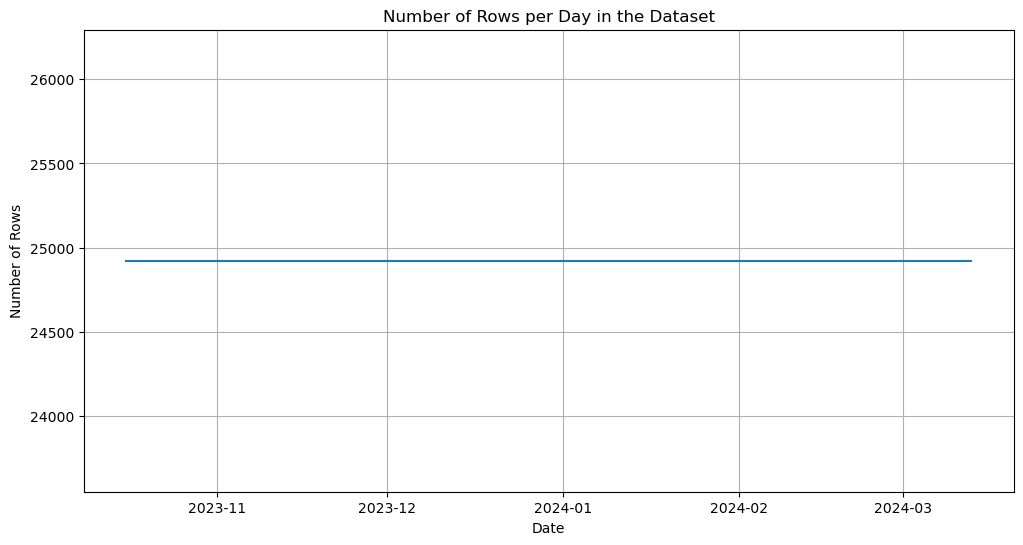

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the 'date' column is in datetime format
df_merged_calendar_rome['date'] = pd.to_datetime(df_merged_calendar_rome['date'])

# Verify the number of rows per day by printing the counts
date_counts = df_merged_calendar_rome.groupby('date').size()
print(date_counts)

# Plot the number of rows for each day
plt.figure(figsize=(12, 6))
plt.plot(date_counts.index, date_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Rows')
plt.title('Number of Rows per Day in the Dataset')
plt.grid(True)
plt.show()

#### Merging Calendar data with Listing data 

In [36]:
import pandas as pd

# Assuming 'id' is the common key in both datasets

# Perform an inner merge to keep only the IDs present in both datasets
final_merged_data = pd.merge(df_merged_calendar_rome, df_listing_cleaned_rome, on='id', how='inner', suffixes=('_merged', '_additional'))

# Count number of rows and unique IDs after merging
total_rows_after = final_merged_data.shape[0]
unique_ids_after = final_merged_data['id'].nunique()

print(f"Total number of rows after merging: {total_rows_after}")
print(f"Total number of unique IDs after merging: {unique_ids_after}")

# Now final_merged_data contains merged information with IDs present in both datasets

Total number of rows after merging: 2823000
Total number of unique IDs after merging: 18820


In [37]:
final_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823000 entries, 0 to 2822999
Columns: 144 entries, id to nearby_transport
dtypes: bool(105), datetime64[ns](1), float64(16), int64(22)
memory usage: 1.1 GB


In [38]:
#check if no columns are duplicated
merged_columns = final_merged_data.columns

print("Columns with suffixes:")
for col in merged_columns:
    if col.endswith('_merged') or col.endswith('_additional'):
        print(col)

Columns with suffixes:
price_merged
price_additional


In [39]:
# Check unique values in 'price_additional' column
unique_prices = final_merged_data['price_merged'].nunique()
print("Unique values in 'price_merged' column:", unique_prices)

# Check unique values in 'price_additional' column
unique_prices = final_merged_data['price_additional'].nunique()
print("Unique values in 'price_additional' column:", unique_prices)

Unique values in 'price_merged' column: 1456
Unique values in 'price_additional' column: 786


In [40]:
#drop the price column from the listing data
final_merged_data = final_merged_data.drop('price_additional', axis=1)
# Rename 'price_merged' to 'price'
final_merged_data.rename(columns={'price_merged': 'price'}, inplace=True)

In [41]:
# Find columns with object type
object_columns = final_merged_data.select_dtypes(include=['object']).columns

print("Columns with object type:")
print(object_columns)

Columns with object type:
Index([], dtype='object')


# Adding additional features 

In [29]:
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Rome Airbnb_Spatiotemporal_Analysis/rome_holidays.xlsx'
holidays_data = pd.read_excel(file_path)

# Convert the 'date' column in both datasets to datetime objects
final_merged_data['date'] = pd.to_datetime(final_merged_data['date'])
holidays_data['Date'] = pd.to_datetime(holidays_data['Date'])

# Merge the Airbnb data with the public holidays data based on the 'date' column
final_merged_data['is_holiday'] = final_merged_data['date'].isin(holidays_data['Date'])

C:\Users\anton\AppData\Local\Temp\ipykernel_23252\1777386877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_calendar_rome['date'] = pd.to_datetime(df_merged_calendar_rome['date'])
C:\Users\anton\AppData\Local\Temp\ipykernel_23252\1777386877.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_calendar_rome['is_holiday'] = df_merged_calendar_rome['date'].isin(holidays_data['Date'])


In [30]:
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Rome Airbnb_Spatiotemporal_Analysis/rome_school_holidays.xlsx'
school_holidays_data = pd.read_excel(file_path)

# Convert the 'date' column in both datasets to datetime objects
final_merged_data['date'] = pd.to_datetime(final_merged_data['date'])
school_holidays_data['Date'] = pd.to_datetime(school_holidays_data['Date'])

# Merge the Airbnb data with the public holidays data based on the 'date' column
final_merged_data['is_school_holiday'] = final_merged_data['date'].isin(school_holidays_data['Date'])

C:\Users\anton\AppData\Local\Temp\ipykernel_23252\2182752429.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_calendar_rome['date'] = pd.to_datetime(df_merged_calendar_rome['date'])
C:\Users\anton\AppData\Local\Temp\ipykernel_23252\2182752429.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_calendar_rome['is_school_holiday'] = df_merged_calendar_rome['date'].isin(school_holidays_data['Date'])


In [31]:
!pip install geopandas
!pip install rtree

In [32]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(
    final_merged_data, 
    geometry=gpd.points_from_xy(final_merged_data.longitude, final_merged_data.latitude)
)

# Create a spatial index for the GeoDataFrame
sindex = gdf.sindex

def count_nearby_listings(row, gdf, sindex, radius_meters=500):
    # Convert the radius in meters to degrees (approximation)
    radius_degrees = radius_meters / 111320
    
    # Find possible matches with rtree index, which returns indices of possible matches
    possible_matches_index = list(sindex.intersection(row.geometry.buffer(radius_degrees).bounds))
    
    # Filter actual matches from possible matches
    possible_matches = gdf.iloc[possible_matches_index]
    actual_matches = possible_matches[possible_matches.geometry.distance(row.geometry) <= radius_degrees]
    
    # Exclude the row itself from the count
    nearby_count = actual_matches.shape[0] - 1
    return nearby_count

# Apply the function to count nearby listings for each listing
gdf['nearby_airbnbs_count'] = gdf.apply(count_nearby_listings, axis=1, gdf=gdf, sindex=sindex)

# If you want to work with a regular DataFrame (excluding the geometry column)
final_merged_data = pd.DataFrame(gdf.drop(columns='geometry'))

# Display the first few rows of the updated DataFrame to verify the new column
print(final_merged_data.head(20))

        id  host_id  host_response_time  host_response_rate  \
0   256695  1350540                   4                   1   
1   258330  1358462                   3                   1   
2   137044   670337                   4                   1   
3   137157   486866                   4                   1   
4   259075  1311777                   4                   1   
5   137713   246365                   4                   1   
6   137724   246365                   4                   1   
7   138192   674843                   4                   2   
8     2737     3047                   3                   3   
9   262254  1374312                   3                   1   
10    3079     3504                   3                   1   
11   11834    44552                   3                   1   
12  139330   679555                   3                   1   
13  140801   685600                   4                   1   
14  262313  1376239                   4                

In [33]:
luxury_amenities = ['sauna', 'hot tub', 'gym', 'pool', 'exercise equipment', 'game console']
final_merged_data['luxury_amenities_score'] = final_merged_data[luxury_amenities].sum(axis=1)

final_merged_data['luxury_amenities_score'].describe()

count    24775.000000
mean         0.094612
std          0.348464
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          6.000000
Name: luxury_amenities_score, dtype: float64

In [34]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import time
from tqdm import tqdm  # Import tqdm for progress bar

# Function to count nearby POIs using spatial indexing
def count_nearby_pois_spatial_index(row, pois_gdf, max_distance=500):
    try:
        # Build spatial index for POIs GeoDataFrame
        pois_sindex = pois_gdf.sindex
        
        # Get nearby POIs using spatial index
        nearby_pois_idx = list(pois_sindex.intersection(row['geometry'].buffer(max_distance).bounds))
        nearby_pois = pois_gdf.iloc[nearby_pois_idx]
        
        # Filter nearby POIs within max_distance
        nearby_pois = nearby_pois[nearby_pois.geometry.distance(row['geometry']) <= max_distance]
        
        return len(nearby_pois)
    
    except Exception as e:
        print(f"Error processing row {row.name}: {str(e)}")
        return None

# Convert your full dataset to a GeoDataFrame and set CRS
gdf_airbnb = gpd.GeoDataFrame(final_merged_data, geometry=gpd.points_from_xy(final_merged_data.longitude, final_merged_data.latitude))
gdf_airbnb.set_crs(epsg=4326, inplace=True)

# Fetch POIs data from OpenStreetMap for your area
area = "Rome, Italy"  # Replace with your area of interest
tags = {"amenity": ["restaurant", "bar"]}
pois_gdf = ox.geometries_from_place(area, tags=tags)

# Find UTM zone for the area and project both GeoDataFrames to this CRS
utm_crs = "EPSG:32633"  # UTM zone for Rome
gdf_airbnb = gdf_airbnb.to_crs(utm_crs)
pois_gdf = pois_gdf.to_crs(utm_crs)

# Measure the processing time for the full dataset
start_time = time.time()

# Apply the function to each Airbnb listing in the full dataset and track progress
tqdm.pandas(desc="Processing rows")
gdf_airbnb['nearby_restaurants_bars'] = gdf_airbnb.progress_apply(
    lambda row: count_nearby_pois_spatial_index(row, pois_gdf, max_distance=1000), axis=1)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for processing the full dataset: {elapsed_time / 60} minutes")

# Convert back to a regular DataFrame if necessary
final_merged_data = pd.DataFrame(gdf_airbnb.drop(columns='geometry'))

# Look at the statistics of the new column
print(final_merged_data['nearby_restaurants_bars'].describe())

C:\Users\anton\AppData\Local\Temp\ipykernel_23252\2312405761.py:33: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois_gdf = ox.geometries_from_place(area, tags=tags)
Processing rows: 100%|██████████| 24775/24775 [02:19<00:00, 177.01it/s]

Time taken for processing the full dataset: 2.3328648686408995 minutes
count    24775.000000
mean       191.757780
std        163.182822
min          0.000000
25%         48.000000
50%        143.000000
75%        306.000000
max        577.000000
Name: nearby_restaurants_bars, dtype: float64


In [35]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import time
from tqdm import tqdm  # Import tqdm for progress bar

# Function to count nearby transport POIs using spatial indexing
def count_nearby_transport_spatial_index(row, transport_gdf, transport_sindex, max_distance=500):
    try:
        # Get nearby transport POIs using spatial index
        nearby_transport_idx = list(transport_sindex.intersection(row['geometry'].buffer(max_distance).bounds))
        nearby_transport = transport_gdf.iloc[nearby_transport_idx]
        
        # Filter nearby transport POIs within max_distance
        nearby_transport = nearby_transport[nearby_transport.geometry.distance(row['geometry']) <= max_distance]
        
        return len(nearby_transport)
    
    except Exception as e:
        print(f"Error processing row {row.name}: {str(e)}")
        return None

# Convert your full dataset to a GeoDataFrame and set CRS
gdf_airbnb = gpd.GeoDataFrame(final_merged_data, geometry=gpd.points_from_xy(final_merged_data.longitude, final_merged_data.latitude))
gdf_airbnb.set_crs(epsg=4326, inplace=True)

# Fetch transport POIs data from OpenStreetMap for your area
area = "Rome, Italy"  # Replace with your area of interest
tags = {'amenity': ['bus_station', 'bus_stop'], 
        'public_transport': ['station', 'stop_position']}
transport_gdf = ox.geometries_from_place(area, tags=tags)

# Find UTM zone for the area and project both GeoDataFrames to this CRS
utm_crs = "EPSG:32633"  # UTM zone for Rome
gdf_airbnb = gdf_airbnb.to_crs(utm_crs)
transport_gdf = transport_gdf.to_crs(utm_crs)

# Build spatial index for transport GeoDataFrame once
transport_sindex = transport_gdf.sindex

# Measure the processing time for the full dataset
start_time = time.time()

# Apply the function to each Airbnb listing in the full dataset and track progress
tqdm.pandas(desc="Processing rows")
gdf_airbnb['nearby_transport'] = gdf_airbnb.progress_apply(
    lambda row: count_nearby_transport_spatial_index(row, transport_gdf, transport_sindex, max_distance=500), axis=1)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for processing the full dataset: {elapsed_time / 60} minutes")

# Convert back to a regular DataFrame if necessary
final_merged_data = pd.DataFrame(gdf_airbnb.drop(columns='geometry'))

# Look at the statistics of the new column
print(final_merged_data['nearby_transport'].describe())

C:\Users\anton\AppData\Local\Temp\ipykernel_23252\4288412101.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  transport_gdf = ox.geometries_from_place(area, tags=tags)
Processing rows: 100%|██████████| 24775/24775 [01:02<00:00, 398.42it/s]

Time taken for processing the full dataset: 1.0364118695259095 minutes
count    24775.000000
mean         7.180141
std          9.731225
min          0.000000
25%          2.000000
50%          5.000000
75%          9.000000
max         61.000000
Name: nearby_transport, dtype: float64


In [42]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

# Check if the required columns are present in the DataFrame
required_columns = ['latitude', 'longitude', 'price', 'date']
missing_columns = [col for col in required_columns if col not in final_merged_data.columns]

if missing_columns:
    raise KeyError(f"The following required columns are missing from the DataFrame: {missing_columns}")

# Initialize a list to store mean neighbor prices for each row
mean_neighbor_prices = []

# Group by date
grouped = final_merged_data.groupby('date')

# Iterate over each group (i.e., each date)
for date, group in tqdm(grouped, desc="Processing dates"):
    if len(group) < 2:
        # If there's less than 2 listings for a date, use the original price for that row
        mean_neighbor_prices.extend(group['price'])
        continue
    
    # Prepare data for KDTree
    coordinates = group[['latitude', 'longitude']].values
    prices = group['price'].values
    
    # Build the KDTree for fast lookup of nearest neighbors
    tree = cKDTree(coordinates)
    
    # Define the number of neighbors to consider (5 closest neighbors)
    k = 5
    
    # Query the tree for the k nearest neighbors for each listing
    distances, indices = tree.query(coordinates, k=k+1)  # k+1 because the nearest neighbor includes the point itself
    
    # Calculate mean price of the nearest neighbors, excluding the point itself
    for idx in indices:
        mean_price = prices[idx[1:]].mean()  # Exclude the point itself
        mean_neighbor_prices.append(mean_price)

# Add the mean_neighbor_prices as a new column in the DataFrame
final_merged_data['mean_price_neighbors'] = np.round(mean_neighbor_prices).astype(int)

# Display the result
print(final_merged_data.head())
print(final_merged_data["mean_price_neighbors"].describe())

Processing dates: 100%|██████████| 150/150 [00:23<00:00,  6.47it/s]


        id       date  available  price  season_Autumn  season_Spring  \
0  5169932 2023-10-16      False  159.0           True          False   
1  5169932 2023-10-17      False  159.0           True          False   
2  5169932 2023-10-18      False  159.0           True          False   
3  5169932 2023-10-19      False  159.0           True          False   
4  5169932 2023-10-20      False  159.0           True          False   

   season_Summer  season_Winter  is_holiday  is_school_holiday  ...  \
0          False          False       False              False  ...   
1          False          False       False              False  ...   
2          False          False       False              False  ...   
3          False          False       False              False  ...   
4          False          False       False              False  ...   

   property_type_Other  room_type_Entire home/apt  room_type_Hotel room  \
0                False                       True          

#### Saving dataset

In [ ]:
final_merged_data.to_csv('MERGED_CLEANED_DATASET.csv', index=False)

In [43]:
final_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823000 entries, 0 to 2822999
Columns: 144 entries, id to mean_price_neighbors
dtypes: bool(105), datetime64[ns](1), float64(16), int32(1), int64(21)
memory usage: 1.1 GB


In [44]:
# Print the name and type of every column
for col in final_merged_data.columns:
    print(f"Column: {col}, Type: {final_merged_data[col].dtype}")

Column: id, Type: int64
Column: date, Type: datetime64[ns]
Column: available, Type: bool
Column: price, Type: float64
Column: season_Autumn, Type: bool
Column: season_Spring, Type: bool
Column: season_Summer, Type: bool
Column: season_Winter, Type: bool
Column: is_holiday, Type: bool
Column: is_school_holiday, Type: bool
Column: host_id, Type: int64
Column: host_response_time, Type: int64
Column: host_response_rate, Type: int64
Column: host_is_superhost, Type: bool
Column: host_listings_count, Type: float64
Column: host_total_listings_count, Type: float64
Column: host_identity_verified, Type: bool
Column: latitude, Type: float64
Column: longitude, Type: float64
Column: accommodates, Type: int64
Column: bathrooms, Type: float64
Column: bedrooms, Type: float64
Column: beds, Type: float64
Column: availability_30, Type: int64
Column: availability_60, Type: int64
Column: availability_90, Type: int64
Column: availability_365, Type: int64
Column: number_of_reviews, Type: int64
Column: number_

# Splitting the data

In [45]:
import pandas as pd
#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Rome Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/MERGED_CLEANED_DATASET.csv'
#read data, and quickly check if it is correctly read in
final_merged_data= pd.read_csv(file_path)

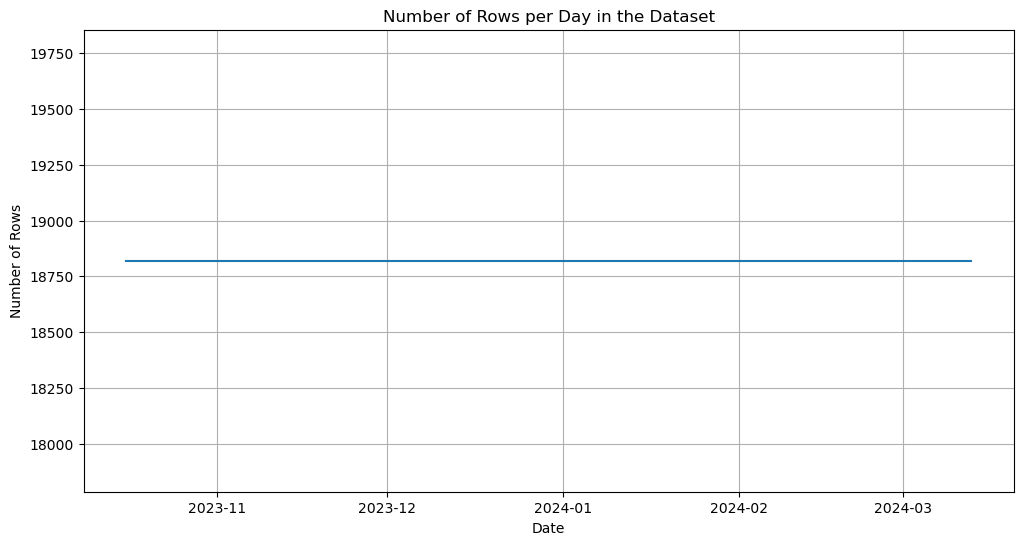

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'date' column is in datetime format
final_merged_data['date'] = pd.to_datetime(final_merged_data['date'])

# Group by date and count the number of rows for each day
date_counts = final_merged_data.groupby('date').size()

# Plot the number of rows for each day
plt.figure(figsize=(12, 6))
plt.plot(date_counts.index, date_counts.values)
plt.xlabel('Date')
plt.ylabel('Number of Rows')
plt.title('Number of Rows per Day in the Dataset')
plt.grid(True)
plt.show()

#### Splitting the data in a 60/20/20 split across IDs and time

In [48]:
import pandas as pd
import numpy as np

# Assuming final_merged_data is already loaded

# Step 1: Convert 'date' column to datetime if it's not already
final_merged_data['date'] = pd.to_datetime(final_merged_data['date'])

# Step 2: Split the time frame of the dataset into 60/20/20 without overlap
sorted_data = final_merged_data.sort_values(by='date')
total_size = len(sorted_data)
train_end_idx = int(0.6 * total_size)
val_end_idx = int(0.8 * total_size)

train_timeframe = sorted_data.iloc[:train_end_idx]
val_timeframe = sorted_data.iloc[train_end_idx:val_end_idx]
test_timeframe = sorted_data.iloc[val_end_idx:]

# To ensure no overlap, remove the first day of val_timeframe and test_timeframe
val_timeframe = val_timeframe[val_timeframe['date'] > train_timeframe['date'].max()]
test_timeframe = test_timeframe[test_timeframe['date'] > val_timeframe['date'].max()]

# Step 3: Extract unique IDs and split them into 60/20/20 randomly
unique_ids = final_merged_data['id'].unique()
np.random.shuffle(unique_ids)

train_size = int(0.6 * len(unique_ids))
val_size = int(0.2 * len(unique_ids))
test_size = len(unique_ids) - train_size - val_size

train_ids = set(unique_ids[:train_size])
val_ids = set(unique_ids[train_size:train_size + val_size])
test_ids = set(unique_ids[train_size + val_size:])

# Step 4: Create the final training, validation, and test sets
final_train_data = train_timeframe[train_timeframe['id'].isin(train_ids)]
final_val_data = val_timeframe[val_timeframe['id'].isin(val_ids)]
final_test_data = test_timeframe[test_timeframe['id'].isin(test_ids)]

# Verification
def verify_splits(train, val, test):
    # Check unique IDs in each split
    train_ids = set(train['id'])
    val_ids = set(val['id'])
    test_ids = set(test['id'])
    
    print(f"Number of unique IDs in train: {len(train_ids)}")
    print(f"Number of unique IDs in val: {len(val_ids)}")
    print(f"Number of unique IDs in test: {len(test_ids)}")
    
    assert train_ids.isdisjoint(val_ids), "Train and validation sets are not disjoint."
    assert train_ids.isdisjoint(test_ids), "Train and test sets are not disjoint."
    assert val_ids.isdisjoint(test_ids), "Validation and test sets are not disjoint."
    
    # Check date ranges
    print(f"Train date range: {train['date'].min()} to {train['date'].max()}")
    print(f"Validation date range: {val['date'].min()} to {val['date'].max()}")
    print(f"Test date range: {test['date'].min()} to {test['date'].max()}")

verify_splits(final_train_data, final_val_data, final_test_data)

Number of unique IDs in train: 11292
Number of unique IDs in val: 3764
Number of unique IDs in test: 3764
Train date range: 2023-10-16 00:00:00 to 2024-01-13 00:00:00
Validation date range: 2024-01-14 00:00:00 to 2024-02-12 00:00:00
Test date range: 2024-02-13 00:00:00 to 2024-03-13 00:00:00


In [ ]:
final_train_data.to_csv('EDA_TRAIN_ROME.csv', index=False)
final_val_data.to_csv('EDA_VALID_ROME.csv', index=False)
final_test_data.to_csv('EDA_TEST_ROME.csv', index=False)

#### Loading in the sets seperatly

In [49]:
import pandas as pd
#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Rome Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/EDA_TRAIN_ROME.csv'
#read data, and quickly check if it is correctly read in
train_data= pd.read_csv(file_path)

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Rome Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/EDA_VALID_ROME.csv'
#read data, and quickly check if it is correctly read in
valid_data= pd.read_csv(file_path)

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Rome Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/EDA_TEST_ROME.csv'
#read data, and quickly check if it is correctly read in
test_data= pd.read_csv(file_path)

In [50]:
train_data["bathrooms"].describe()

count    1.016280e+06
mean     1.314559e+00
std      7.134463e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.250000e+01
Name: bathrooms, dtype: float64

In [51]:
import pandas as pd

# Assuming train_data, valid_data, and test_data are the original datasets

# Function to count unique IDs and check overlaps
def analyze_ids(train_data, valid_data, test_data):
    # Count unique IDs in each dataset
    unique_train_ids = set(train_data['id'])
    unique_valid_ids = set(valid_data['id'])
    unique_test_ids = set(test_data['id'])
    
    print("Unique ID Counts:")
    print(f"Train IDs: {len(unique_train_ids)}")
    print(f"Validation IDs: {len(unique_valid_ids)}")
    print(f"Test IDs: {len(unique_test_ids)}")
    print()
    
    # Check for overlaps
    overlap_train_valid = unique_train_ids.intersection(unique_valid_ids)
    overlap_train_test = unique_train_ids.intersection(unique_test_ids)
    overlap_valid_test = unique_valid_ids.intersection(unique_test_ids)
    
    print("Overlaps:")
    print(f"Train and Validation overlap: {len(overlap_train_valid)} IDs")
    print(f"Train and Test overlap: {len(overlap_train_test)} IDs")
    print(f"Validation and Test overlap: {len(overlap_valid_test)} IDs")
    
    # Optionally, print some of the overlapping IDs
    if len(overlap_train_valid) > 0:
        print("\nSample overlapping IDs between Train and Validation:")
        print(list(overlap_train_valid)[:10])  # Print a sample of 10 overlapping IDs
        
    if len(overlap_train_test) > 0:
        print("\nSample overlapping IDs between Train and Test:")
        print(list(overlap_train_test)[:10])  # Print a sample of 10 overlapping IDs
        
    if len(overlap_valid_test) > 0:
        print("\nSample overlapping IDs between Validation and Test:")
        print(list(overlap_valid_test)[:10])  # Print a sample of 10 overlapping IDs

# Analyze the IDs in the original datasets
analyze_ids(train_data, valid_data, test_data)

Unique ID Counts:
Train IDs: 11292
Validation IDs: 3764
Test IDs: 3764

Overlaps:
Train and Validation overlap: 0 IDs
Train and Test overlap: 0 IDs
Validation and Test overlap: 0 IDs


# EDA on training data

### Summary Descriptive 

In [52]:
import pandas as pd
import numpy as np

# Assuming 'final_merged_data' is your dataset
# Ensure 'date' column is in datetime format
train_data['date'] = pd.to_datetime(train_data['date'])

# Descriptive statistics for numerical columns
numerical_cols = train_data.select_dtypes(include=[np.number]).columns
print("Descriptive Statistics for Numerical Columns:")
print(train_data[numerical_cols].describe().transpose())

# Descriptive statistics for boolean columns
boolean_cols = train_data.select_dtypes(include=[bool]).columns
print("\nDescriptive Statistics for Boolean Columns:")
boolean_stats = train_data[boolean_cols].astype(int).describe().transpose()
boolean_stats.index = boolean_stats.index.map(lambda x: f'{x} (True/False)')
print(boolean_stats)

# Descriptive statistics for categorical columns
categorical_cols = train_data.select_dtypes(include=[object]).columns
print("\nDescriptive Statistics for Categorical Columns:")
for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(f"Number of unique values: {train_data[col].nunique()}")
    print(f"Top value: {train_data[col].mode()[0]}")
    print(f"Frequency of top value: {train_data[col].value_counts().iloc[0]}")
    print(f"Value counts:\n{train_data[col].value_counts()}\n")

# For datetime columns, show min and max
date_columns = train_data.select_dtypes(include=[np.datetime64]).columns
print("\nDate Range for Date Columns:")
for column in date_columns:
    print(f"\nColumn: {column}")
    print(f"Start Date: {train_data[column].min()}")
    print(f"End Date: {train_data[column].max()}")

Descriptive Statistics for Numerical Columns:
                                                  count          mean  \
id                                            1016280.0  2.069064e+15   
price                                         1016280.0  2.128571e+02   
host_id                                       1016280.0  1.047065e+08   
host_response_time                            1016280.0  3.177382e+00   
host_response_rate                            1016280.0  1.741587e+00   
host_listings_count                           1016280.0  1.406429e+01   
host_total_listings_count                     1016280.0  2.058546e+01   
latitude                                      1016280.0  4.189215e+01   
longitude                                     1016280.0  1.248030e+01   
accommodates                                  1016280.0  3.739904e+00   
bathrooms                                     1016280.0  1.314559e+00   
bedrooms                                      1016280.0  1.446954e+00   
beds 

                                            count      mean       std  min  \
available (True/False)                  1016280.0  0.536358  0.498677  0.0   
season_Autumn (True/False)              1016280.0  0.511111  0.499877  0.0   
season_Spring (True/False)              1016280.0  0.000000  0.000000  0.0   
season_Summer (True/False)              1016280.0  0.000000  0.000000  0.0   
season_Winter (True/False)              1016280.0  0.488889  0.499877  0.0   
...                                           ...       ...       ...  ...   
property_type_Other (True/False)        1016280.0  0.119996  0.324958  0.0   
room_type_Entire home/apt (True/False)  1016280.0  0.676674  0.467746  0.0   
room_type_Hotel room (True/False)       1016280.0  0.035335  0.184625  0.0   
room_type_Private room (True/False)     1016280.0  0.283829  0.450855  0.0   
room_type_Shared room (True/False)      1016280.0  0.004162  0.064381  0.0   

                                        25%  50%  75%  max  
av

In [53]:
import pandas as pd

# Assuming train_data is your DataFrame

# Find all boolean columns
bool_columns = train_data.select_dtypes(include='bool').columns

# Function to calculate percentages
def calculate_percentages(column):
    value_counts = train_data[column].value_counts(normalize=True) * 100
    return value_counts

# Print percentages for each boolean column
for column in bool_columns:
    percentages = calculate_percentages(column)
    print(f"Percentages for {column}:")
    print(f"0: {percentages.get(False, 0):.2f}%")
    print(f"1: {percentages.get(True, 0):.2f}%")
    print("-" * 30)

Percentages for available:
0: 46.36%
1: 53.64%
------------------------------
Percentages for season_Autumn:
0: 48.89%
1: 51.11%
------------------------------
Percentages for season_Spring:
0: 100.00%
1: 0.00%
------------------------------
Percentages for season_Summer:
0: 100.00%
1: 0.00%
------------------------------
Percentages for season_Winter:
0: 51.11%
1: 48.89%
------------------------------
Percentages for is_holiday:
0: 93.33%
1: 6.67%
------------------------------
Percentages for is_school_holiday:
0: 82.22%
1: 17.78%
------------------------------
Percentages for host_is_superhost:
0: 68.14%
1: 31.86%
------------------------------
Percentages for host_identity_verified:
0: 11.62%
1: 88.38%
------------------------------
Percentages for instant_bookable:
0: 44.20%
1: 55.80%
------------------------------
Percentages for Bidet:
0: 67.94%
1: 32.06%
------------------------------
Percentages for game console:
0: 98.94%
1: 1.06%
------------------------------
Percentages fo

Percentages for room_type_Hotel room:
0: 96.47%
1: 3.53%
------------------------------
Percentages for room_type_Private room:
0: 71.62%
1: 28.38%
------------------------------
Percentages for room_type_Shared room:
0: 99.58%
1: 0.42%
------------------------------


### Outliers detection

#### Boxplots

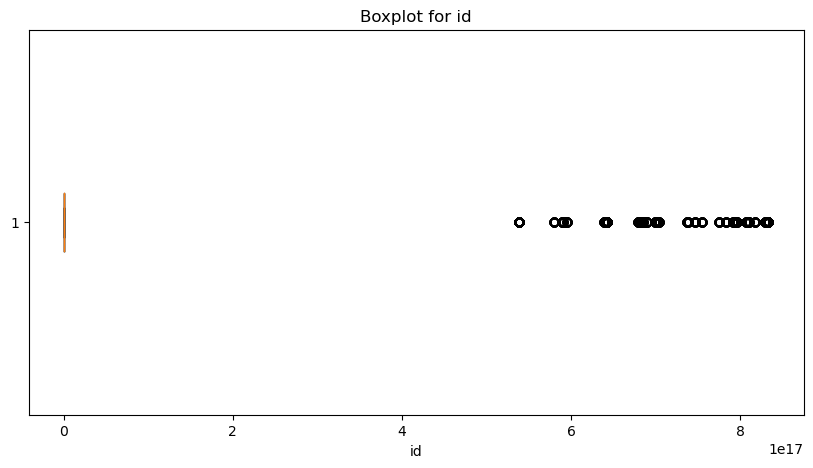

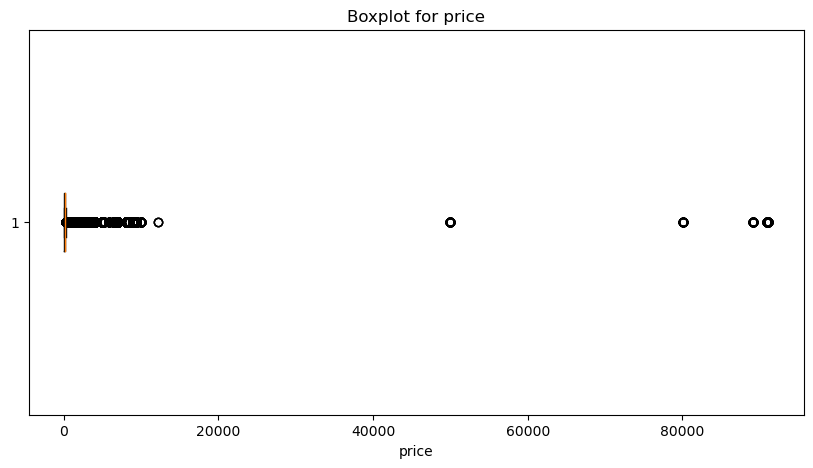

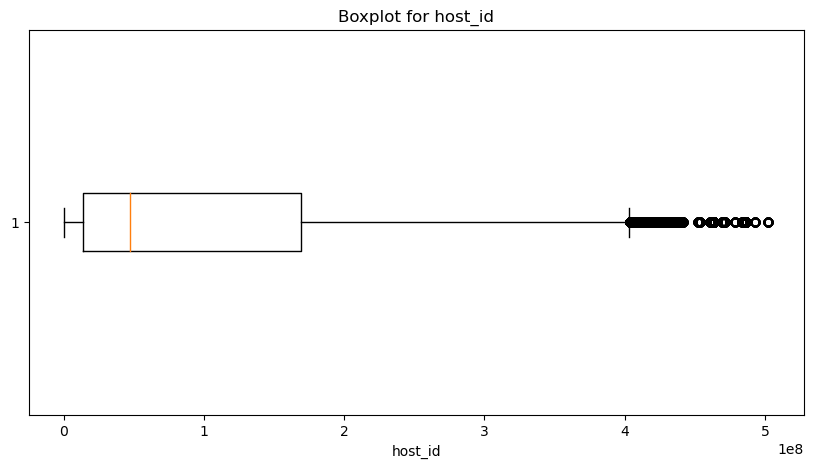

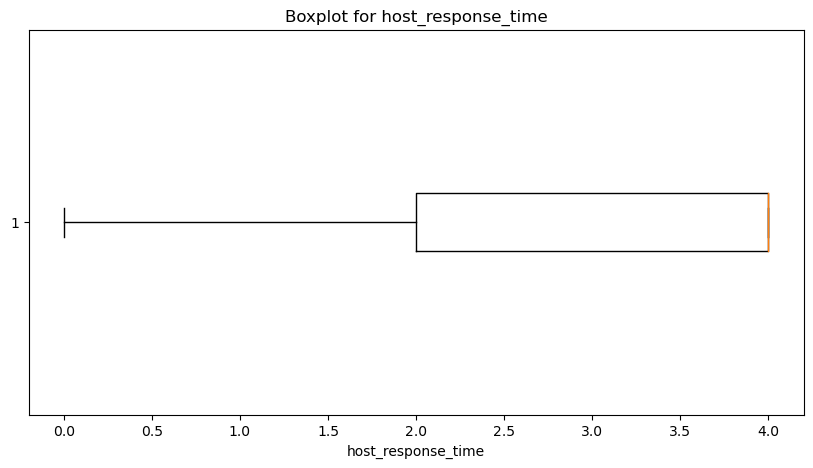

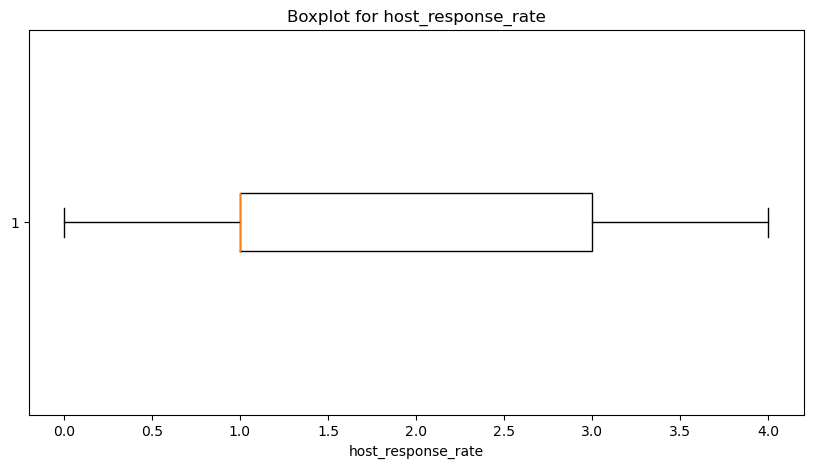

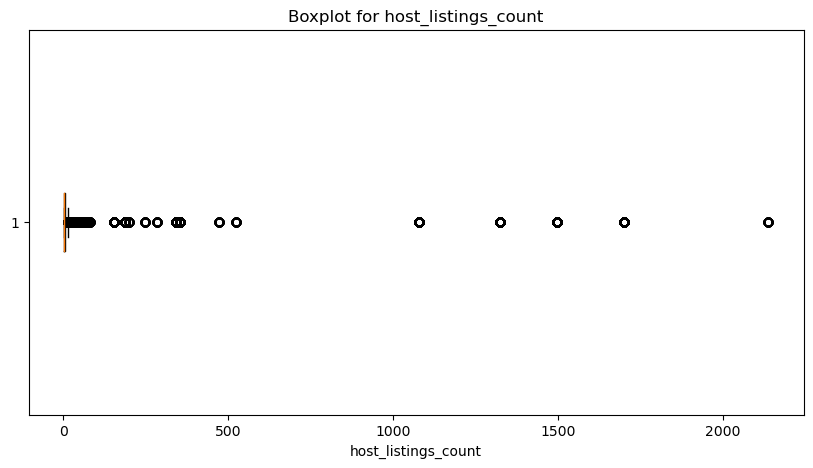

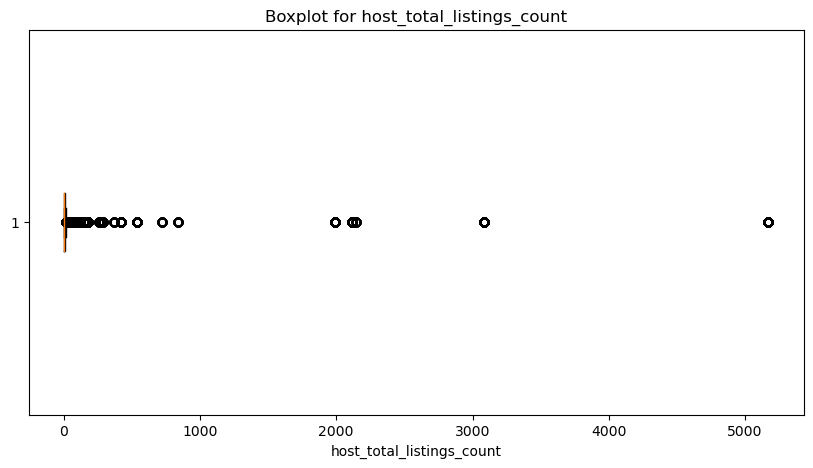

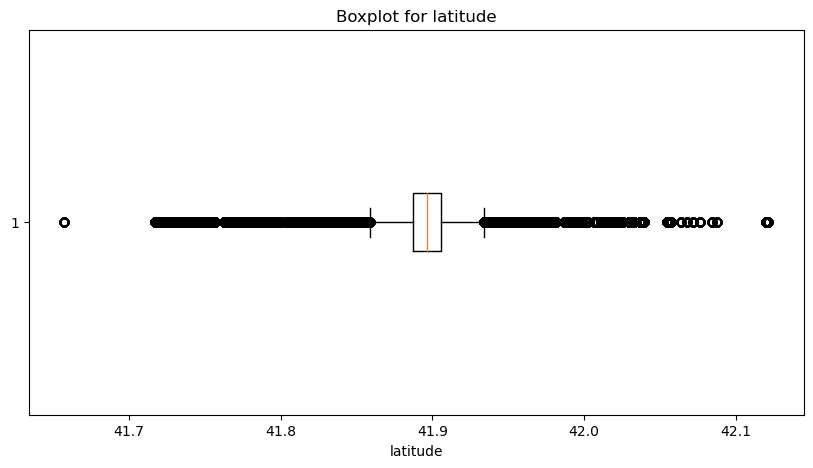

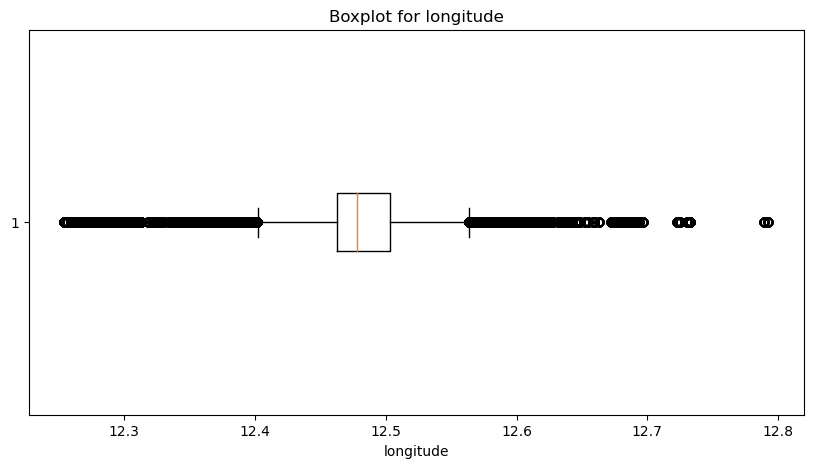

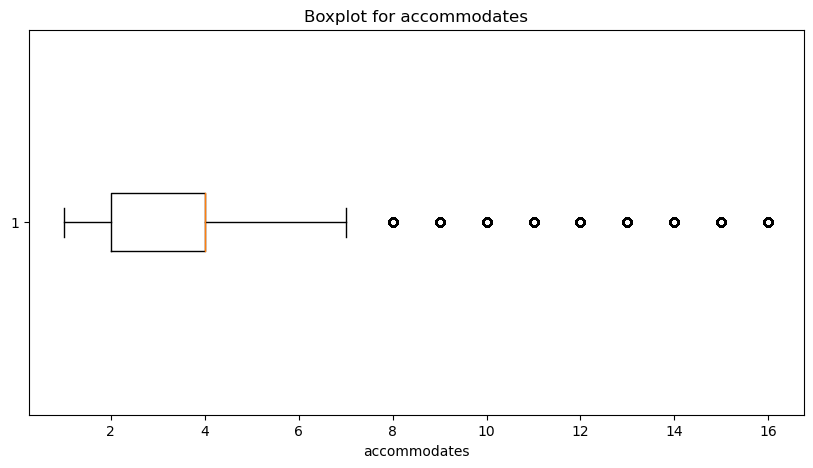

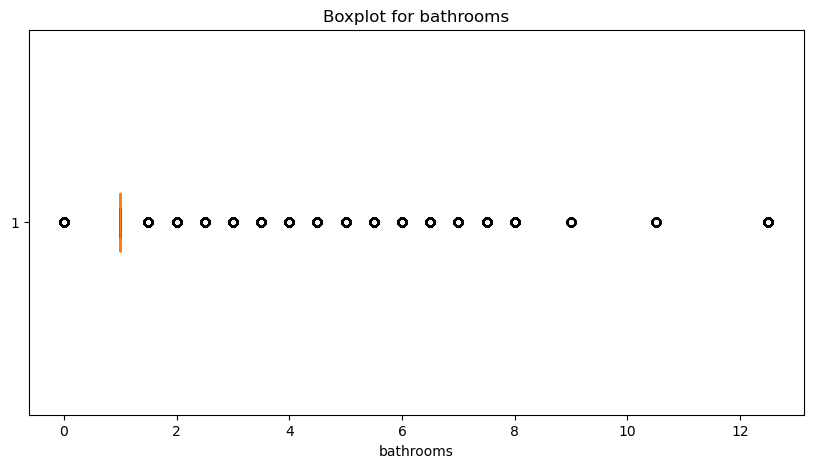

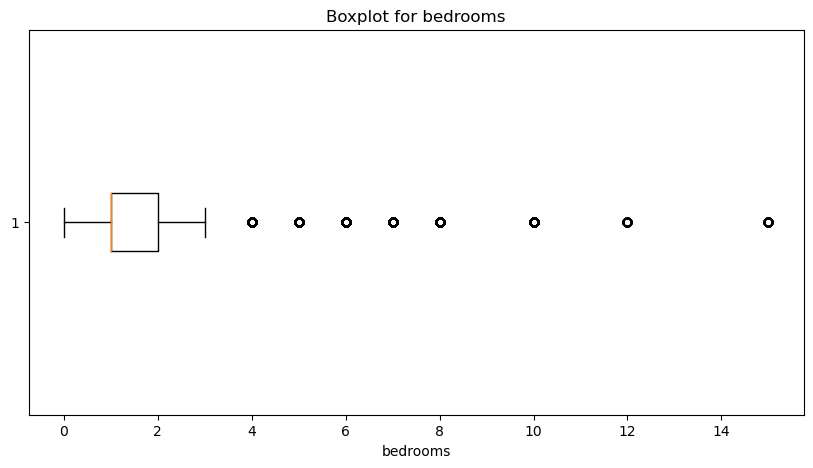

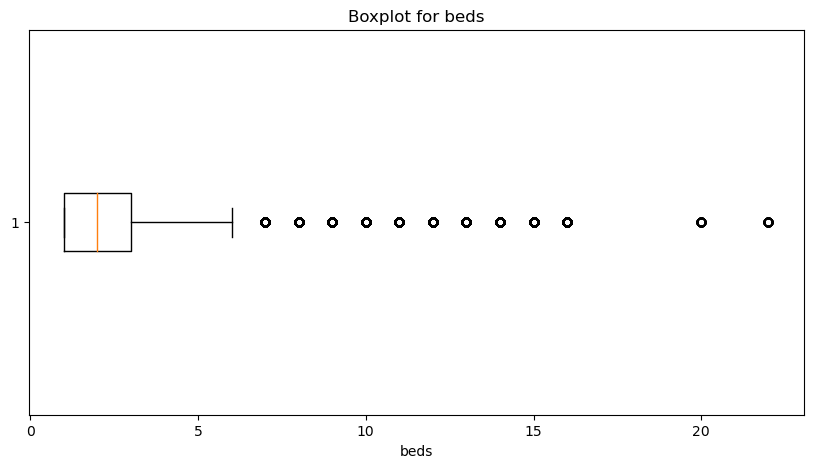

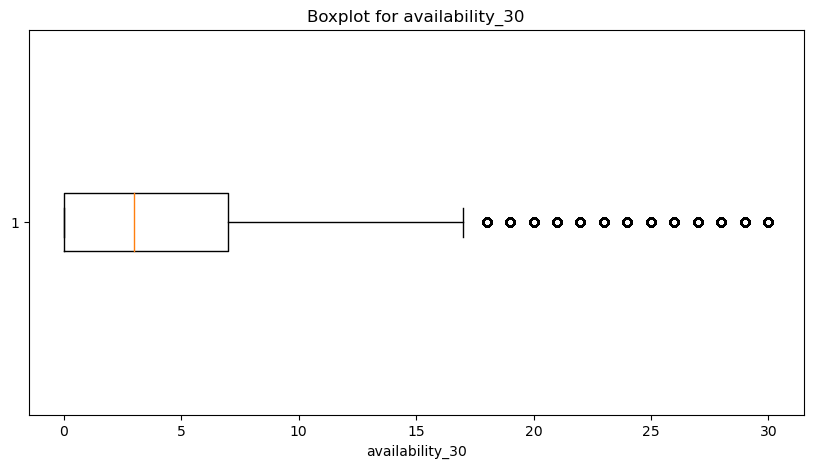

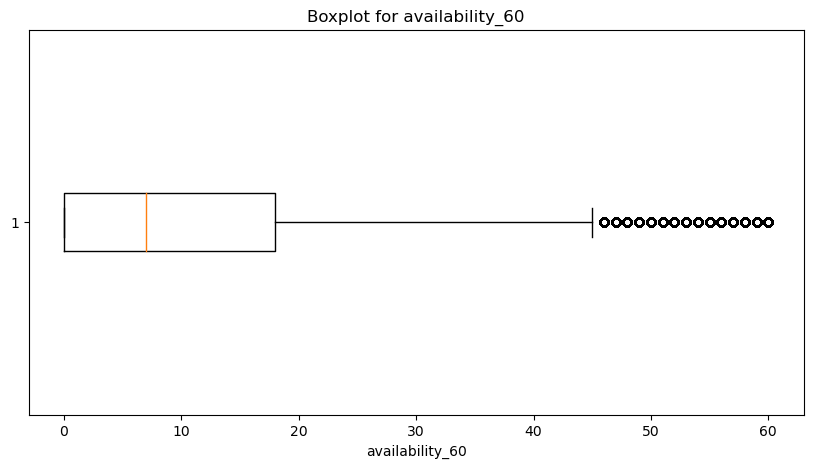

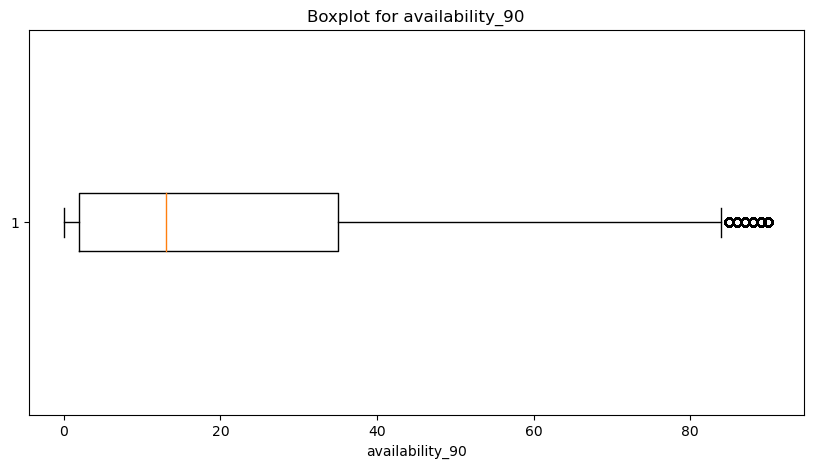

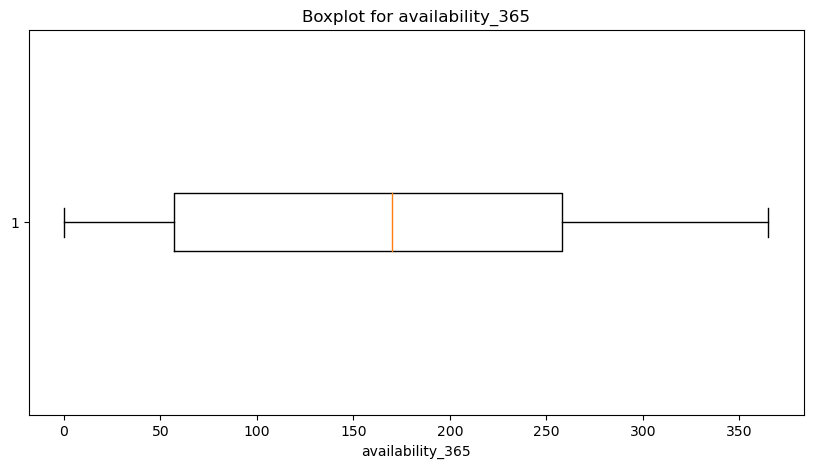

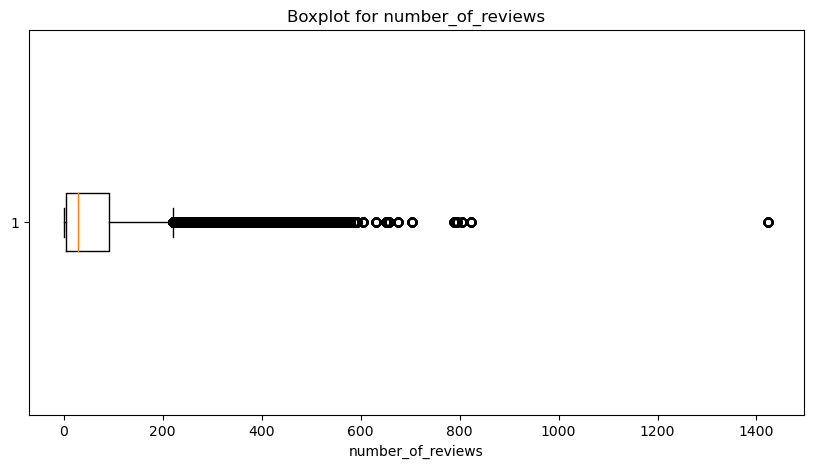

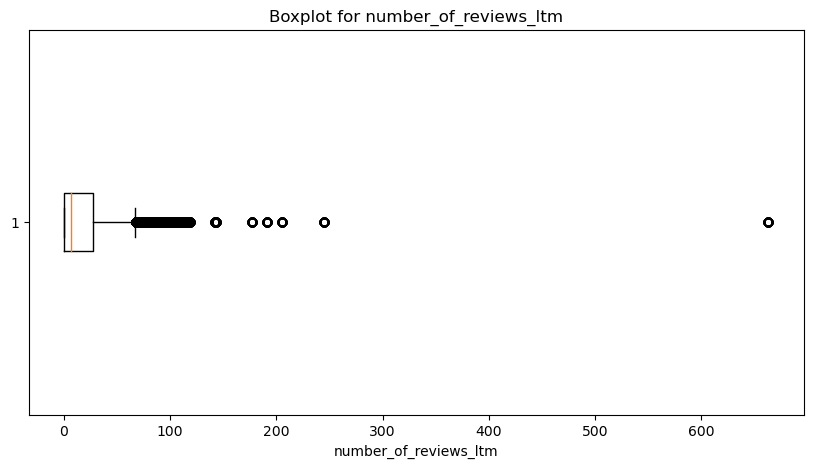

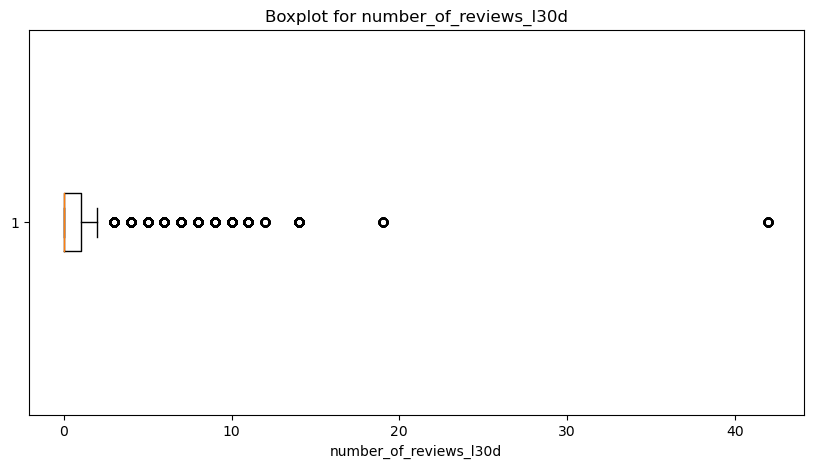

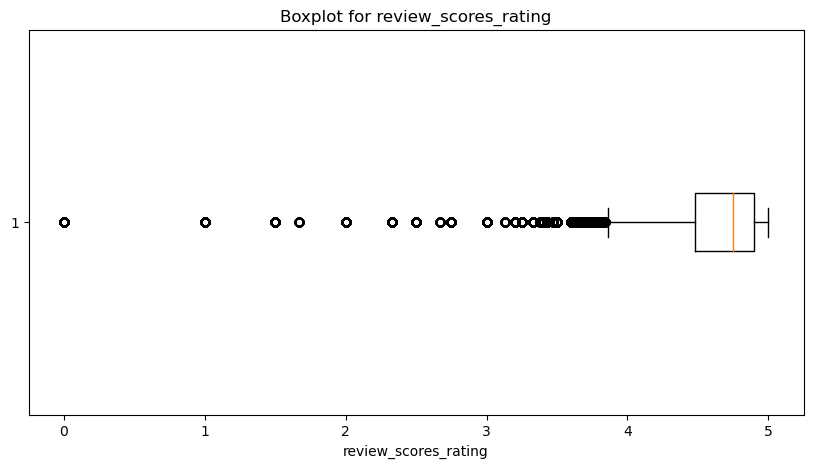

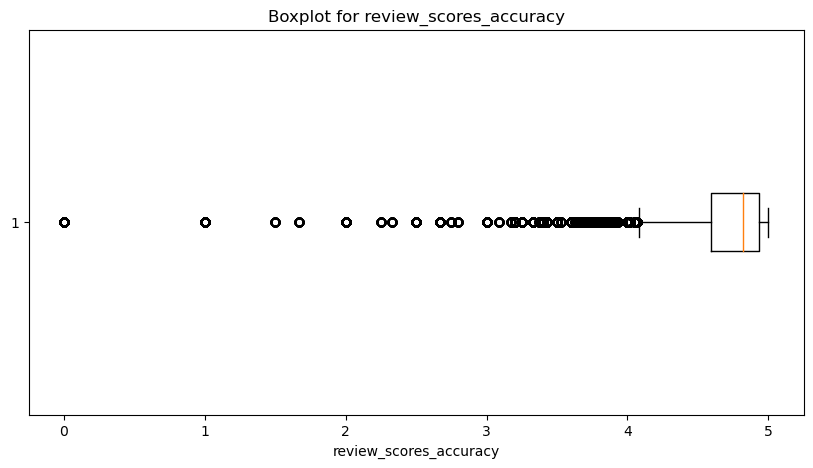

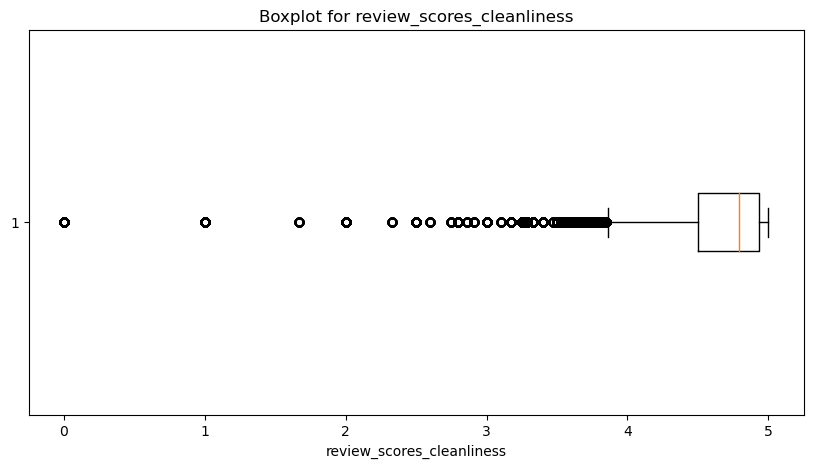

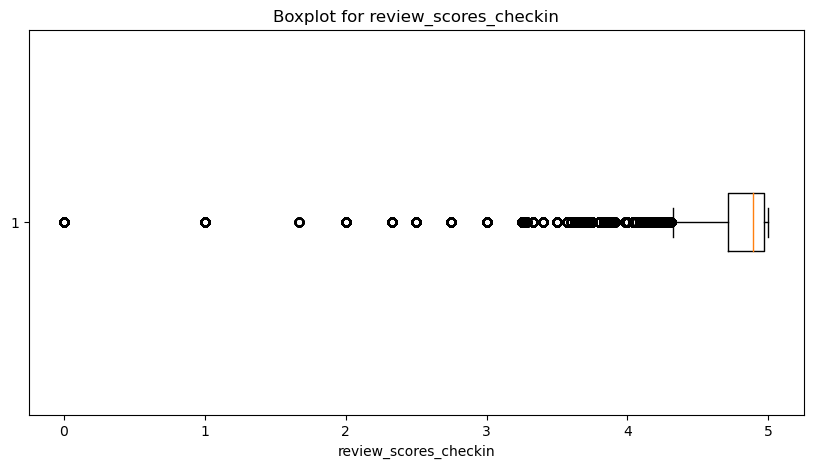

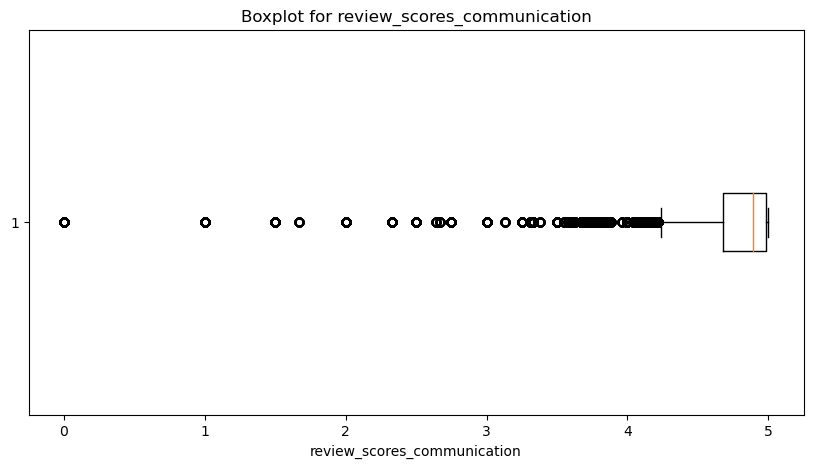

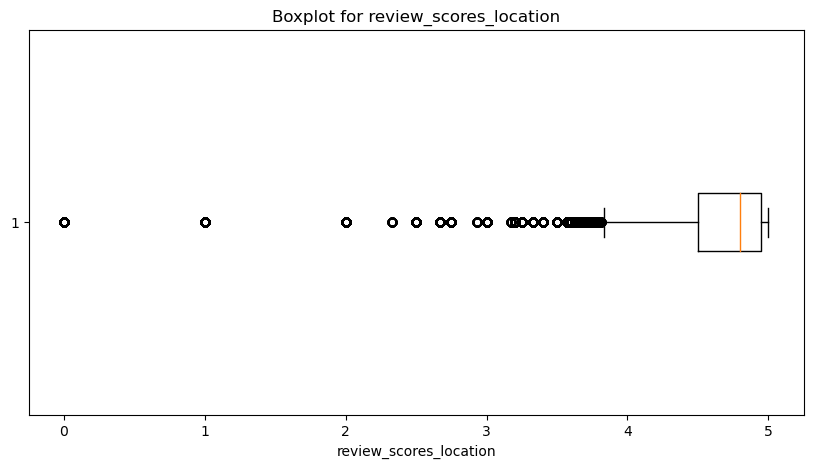

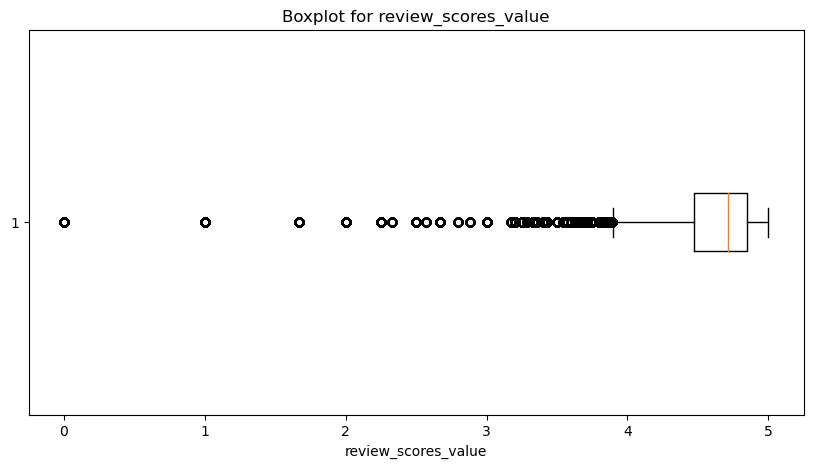

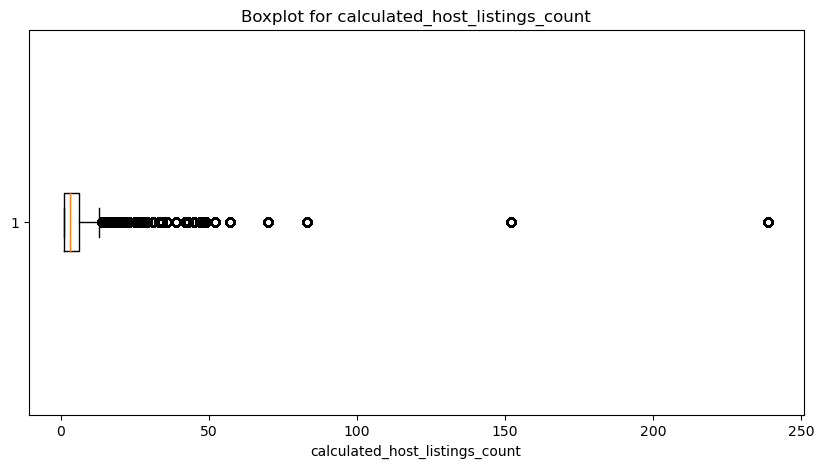

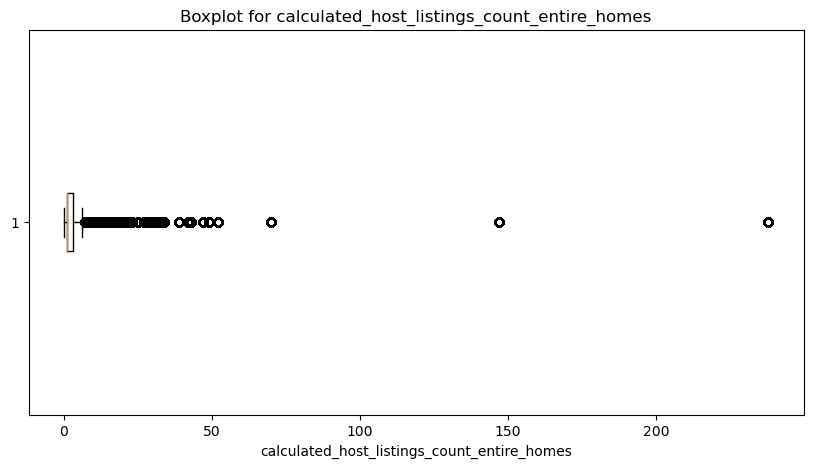

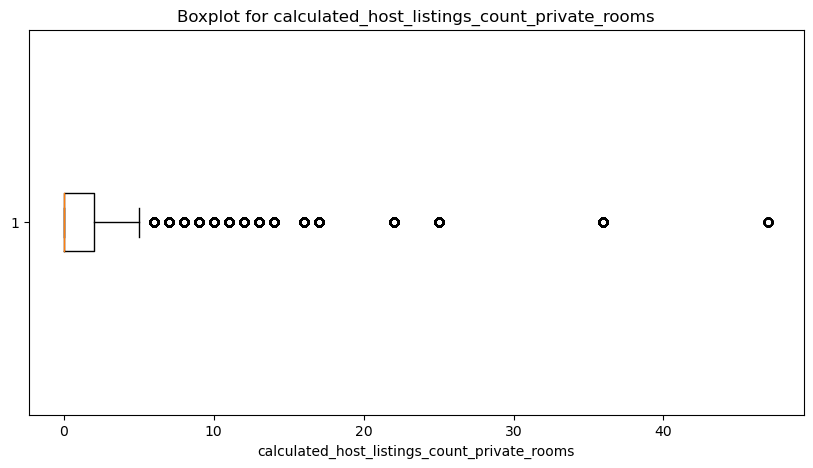

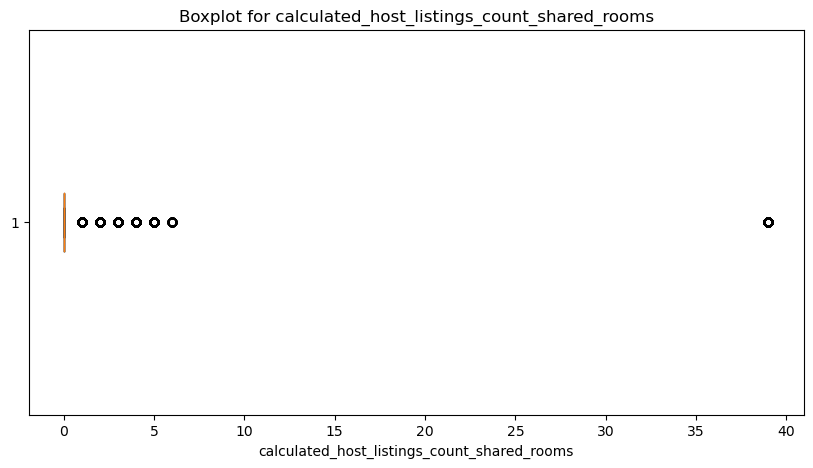

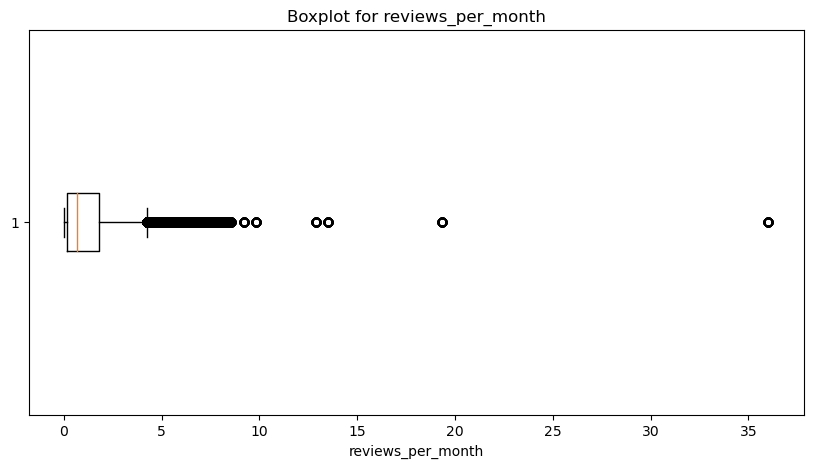

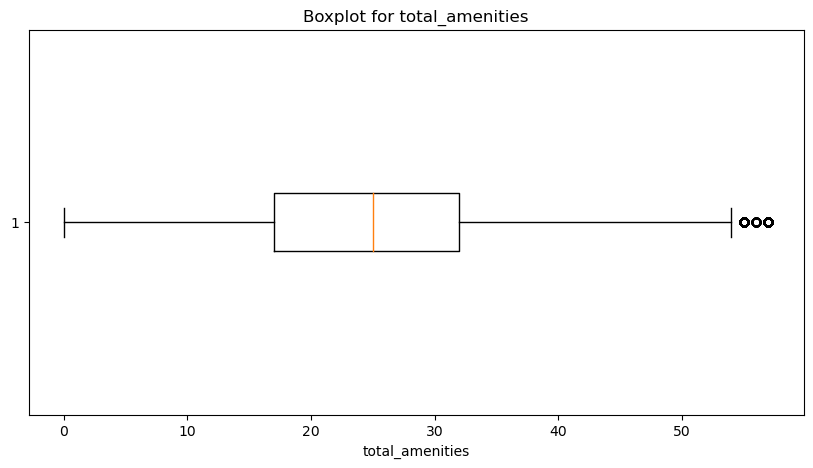

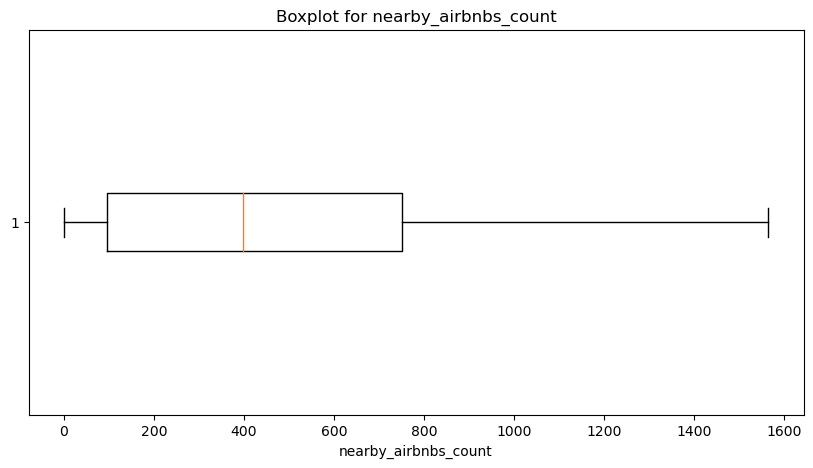

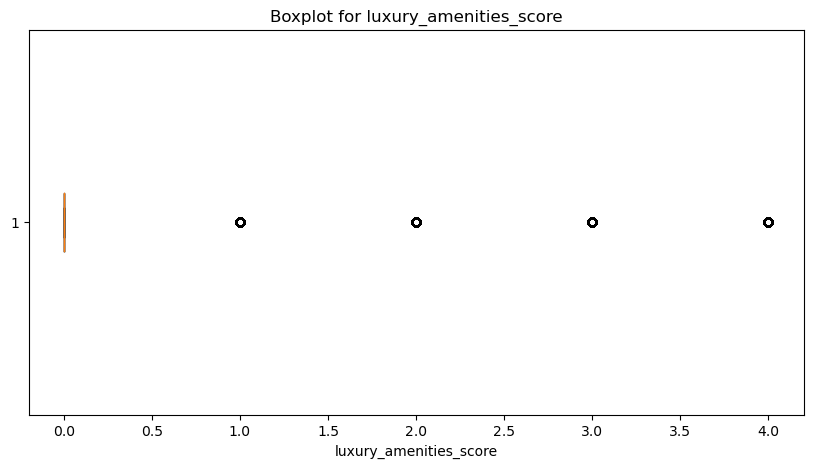

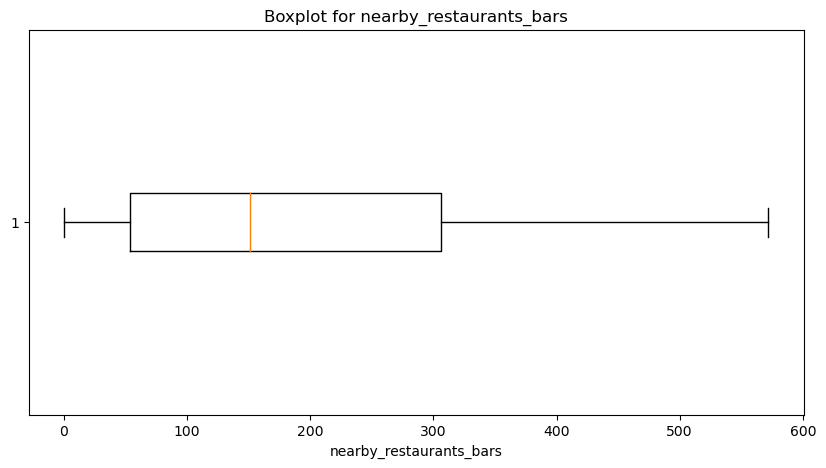

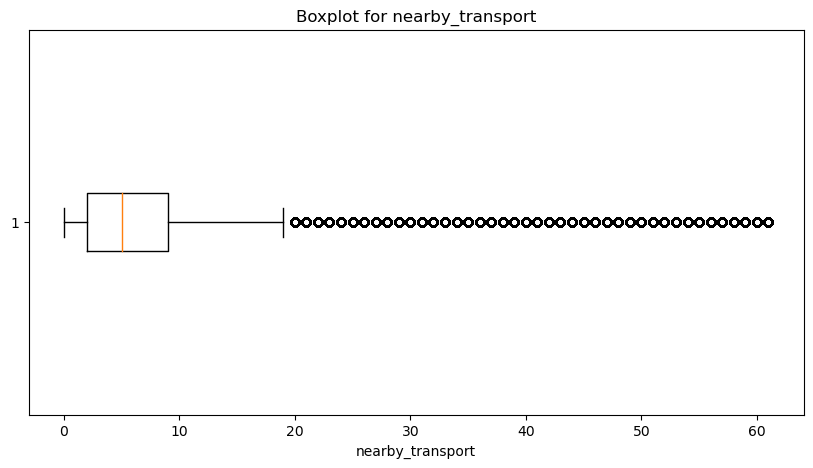

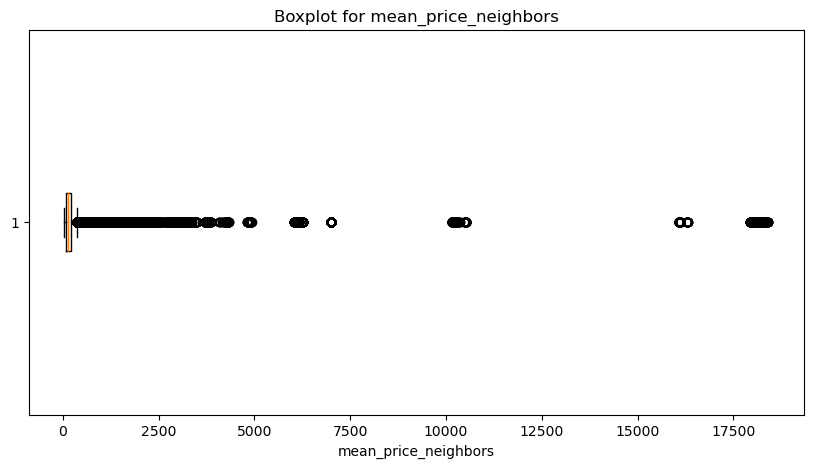

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Select only numerical columns
numerical_columns = train_data.select_dtypes(include=['number']).columns

# Plot boxplots for each numerical column
for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    plt.boxplot(train_data[column].dropna(), vert=False)
    plt.title(f'Boxplot for {column}')
    plt.xlabel(column)
    plt.show()

#### Z-scores with threshold 3

In [55]:
import pandas as pd
import numpy as np

# Ensure the required columns are present in the DataFrame
excluded_columns = ['longitude', 'latitude', 'id', 'host_id']

# Select numerical columns except the excluded ones
numerical_columns = train_data.select_dtypes(include=['number']).columns
numerical_columns = [col for col in numerical_columns if col not in excluded_columns]

# Function to identify outliers using z-score
def identify_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    outliers = df[z_scores > threshold]
    return outliers

# Analyze outliers for each numerical column
for column in numerical_columns:
    outliers = identify_outliers_zscore(train_data, column)
    num_outliers = len(outliers)
    
    # Print outlier statistics
    print(f"Number of outliers in '{column}': {num_outliers}")

Number of outliers in 'price': 2563
Number of outliers in 'host_response_time': 0
Number of outliers in 'host_response_rate': 0
Number of outliers in 'host_listings_count': 16470
Number of outliers in 'host_total_listings_count': 7020
Number of outliers in 'accommodates': 14940
Number of outliers in 'bathrooms': 18450
Number of outliers in 'bedrooms': 11070
Number of outliers in 'beds': 13410
Number of outliers in 'availability_30': 36180
Number of outliers in 'availability_60': 17370
Number of outliers in 'availability_90': 0
Number of outliers in 'availability_365': 0
Number of outliers in 'number_of_reviews': 23130
Number of outliers in 'number_of_reviews_ltm': 11430
Number of outliers in 'number_of_reviews_l30d': 13410
Number of outliers in 'review_scores_rating': 0
Number of outliers in 'review_scores_accuracy': 0
Number of outliers in 'review_scores_cleanliness': 0
Number of outliers in 'review_scores_checkin': 0
Number of outliers in 'review_scores_communication': 0
Number of ou

In [56]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016280 entries, 0 to 1016279
Columns: 144 entries, id to mean_price_neighbors
dtypes: bool(105), datetime64[ns](1), float64(16), int64(22)
memory usage: 404.2 MB


In [57]:
import pandas as pd
import numpy as np

# Columns that need to be corrected for outliers
columns_to_correct = [
    'price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'total_amenities',
    'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'reviews_per_month', 'nearby_transport'
]

# Make a copy of the train_data
train_data_corrected = train_data.copy()

# Function to identify and remove outliers using z-score
def remove_outliers_zscore(df, columns, threshold=3):
    for column in columns:
        z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
        df = df[z_scores <= threshold]
    return df

# Apply the function to remove outliers
train_data_corrected = remove_outliers_zscore(train_data_corrected, columns_to_correct)

# Print the sizes of the original and corrected datasets to verify
print(f"Original train_data size: {train_data.shape[0]}")
print(f"Corrected train_data size: {train_data_corrected.shape[0]}")

# Optionally, save the corrected dataset to a CSV file
# train_data_corrected.to_csv('train_data_corrected.csv', index=False)

Original train_data size: 1016280
Corrected train_data size: 772602


#### Recalculate mean_price_neighbors for train set

In [58]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

# Check if the required columns are present in the DataFrame
required_columns = ['latitude', 'longitude', 'price', 'date']
missing_columns = [col for col in required_columns if col not in train_data_corrected.columns]

if missing_columns:
    raise KeyError(f"The following required columns are missing from the DataFrame: {missing_columns}")

# Initialize a list to store mean neighbor prices for each row
mean_neighbor_prices = []

# Group by date
grouped = train_data_corrected.groupby('date')

# Iterate over each group (i.e., each date)
for date, group in tqdm(grouped, desc="Processing dates"):
    if len(group) < 2:
        # If there's less than 2 listings for a date, use the original price for that row
        mean_neighbor_prices.extend(group['price'])
        continue
    
    # Prepare data for KDTree
    coordinates = group[['latitude', 'longitude']].values
    prices = group['price'].values
    
    # Build the KDTree for fast lookup of nearest neighbors
    tree = cKDTree(coordinates)
    
    # Define the number of neighbors to consider (5 closest neighbors)
    k = 5
    
    # Query the tree for the k nearest neighbors for each listing
    distances, indices = tree.query(coordinates, k=k+1)  # k+1 because the nearest neighbor includes the point itself
    
    # Calculate mean price of the nearest neighbors, excluding the point itself
    for idx in indices:
        mean_price = prices[idx[1:]].mean()  # Exclude the point itself
        mean_neighbor_prices.append(mean_price)

# Add the mean_neighbor_prices as a new column in the DataFrame
train_data_corrected['mean_price_neighbors'] = np.round(mean_neighbor_prices).astype(int)

# Display the result
print(train_data_corrected["mean_price_neighbors"].describe())

Processing dates: 100%|██████████| 90/90 [00:05<00:00, 15.41it/s]


count    772602.000000
mean        139.215632
std         107.216632
min          28.000000
25%          80.000000
50%         113.000000
75%         164.000000
max        3072.000000
Name: mean_price_neighbors, dtype: float64


#### Cap the validation and test set based on train set

In [59]:
import pandas as pd
import numpy as np

# Columns that need to be corrected for outliers
columns_to_correct = [
    'price', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'total_amenities',
    'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
    'reviews_per_month', 'nearby_transport'
]

# Make copies of the valid_data and test_data
valid_data_corrected = valid_data.copy()
test_data_corrected = test_data.copy()

# Calculate the maximum values for the specified columns in the train_data_corrected
max_values = train_data_corrected[columns_to_correct].max()

# Function to remove rows with values higher than the max values in the specified columns
def remove_rows_above_max(df, max_values):
    for column in max_values.index:
        df = df[df[column] <= max_values[column]]
    return df

# Apply the function to valid_data and test_data
valid_data_corrected = remove_rows_above_max(valid_data_corrected, max_values)
test_data_corrected = remove_rows_above_max(test_data_corrected, max_values)

# Print the sizes of the original and corrected datasets to verify
print(f"Original valid_data size: {valid_data.shape[0]}")
print(f"Corrected valid_data size: {valid_data_corrected.shape[0]}")
print(f"Original test_data size: {test_data.shape[0]}")
print(f"Corrected test_data size: {test_data_corrected.shape[0]}")

Original valid_data size: 112920
Corrected valid_data size: 85725
Original test_data size: 112920
Corrected test_data size: 85755


#### Recalculate mean_price_neighbors for valid and test set

In [60]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

# Check if the required columns are present in the DataFrame
required_columns = ['latitude', 'longitude', 'price', 'date']
missing_columns = [col for col in required_columns if col not in valid_data_corrected.columns]

if missing_columns:
    raise KeyError(f"The following required columns are missing from the DataFrame: {missing_columns}")

# Initialize a list to store mean neighbor prices for each row
mean_neighbor_prices = []

# Group by date
grouped = valid_data_corrected.groupby('date')

# Iterate over each group (i.e., each date)
for date, group in tqdm(grouped, desc="Processing dates"):
    if len(group) < 2:
        # If there's less than 2 listings for a date, use the original price for that row
        mean_neighbor_prices.extend(group['price'])
        continue
    
    # Prepare data for KDTree
    coordinates = group[['latitude', 'longitude']].values
    prices = group['price'].values
    
    # Build the KDTree for fast lookup of nearest neighbors
    tree = cKDTree(coordinates)
    
    # Define the number of neighbors to consider (5 closest neighbors)
    k = 5
    
    # Query the tree for the k nearest neighbors for each listing
    distances, indices = tree.query(coordinates, k=k+1)  # k+1 because the nearest neighbor includes the point itself
    
    # Calculate mean price of the nearest neighbors, excluding the point itself
    for idx in indices:
        mean_price = prices[idx[1:]].mean()  # Exclude the point itself
        mean_neighbor_prices.append(mean_price)

# Add the mean_neighbor_prices as a new column in the DataFrame
valid_data_corrected['mean_price_neighbors'] = np.round(mean_neighbor_prices).astype(int)

# Display the result
print(valid_data_corrected["mean_price_neighbors"].describe())

Processing dates: 100%|██████████| 30/30 [00:00<00:00, 48.52it/s]

count    85725.000000
mean       140.627110
std        127.591701
min         33.000000
25%         77.000000
50%        105.000000
75%        154.000000
max       2100.000000
Name: mean_price_neighbors, dtype: float64


In [61]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

# Check if the required columns are present in the DataFrame
required_columns = ['latitude', 'longitude', 'price', 'date']
missing_columns = [col for col in required_columns if col not in test_data_corrected.columns]

if missing_columns:
    raise KeyError(f"The following required columns are missing from the DataFrame: {missing_columns}")

# Initialize a list to store mean neighbor prices for each row
mean_neighbor_prices = []

# Group by date
grouped = test_data_corrected.groupby('date')

# Iterate over each group (i.e., each date)
for date, group in tqdm(grouped, desc="Processing dates"):
    if len(group) < 2:
        # If there's less than 2 listings for a date, use the original price for that row
        mean_neighbor_prices.extend(group['price'])
        continue
    
    # Prepare data for KDTree
    coordinates = group[['latitude', 'longitude']].values
    prices = group['price'].values
    
    # Build the KDTree for fast lookup of nearest neighbors
    tree = cKDTree(coordinates)
    
    # Define the number of neighbors to consider (5 closest neighbors)
    k = 5
    
    # Query the tree for the k nearest neighbors for each listing
    distances, indices = tree.query(coordinates, k=k+1)  # k+1 because the nearest neighbor includes the point itself
    
    # Calculate mean price of the nearest neighbors, excluding the point itself
    for idx in indices:
        mean_price = prices[idx[1:]].mean()  # Exclude the point itself
        mean_neighbor_prices.append(mean_price)

# Add the mean_neighbor_prices as a new column in the DataFrame
test_data_corrected['mean_price_neighbors'] = np.round(mean_neighbor_prices).astype(int)

# Display the result
print(test_data_corrected["mean_price_neighbors"].describe())

Processing dates: 100%|██████████| 30/30 [00:00<00:00, 49.62it/s]

count    85755.000000
mean       130.807556
std         89.258834
min         21.000000
25%         77.000000
50%        106.000000
75%        153.000000
max       1163.000000
Name: mean_price_neighbors, dtype: float64


In [ ]:
train_data_corrected.to_csv('train_data_corrected_outliers.csv', index=False)
valid_data_corrected.to_csv('valid_data_corrected_outliers.csv', index=False)
test_data_corrected.to_csv('test_data_corrected_outliers.csv', index=False)

### Correlation Analysis 

In [62]:
!pip install dask

C:\Users\anton\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
C:\Users\anton\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)
C:\Users\anton\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)


Sampling data...
Removing constant columns: ['season_Spring', 'season_Summer', 'calculated_host_listings_count_shared_rooms', 'room_type_Shared room']
Computing correlation matrix...

Correlations with price:
mean_price_neighbors: 0.33
nearby_restaurants_bars: 0.24
neighbourhood_I Centro Storico: 0.20
accommodates: 0.20
availability_60: 0.18
nearby_airbnbs_count: 0.18
availability_30: 0.17
availability_90: 0.17
calculated_host_listings_count: 0.16
bathrooms: 0.16
bedrooms: 0.15
host_listings_count: 0.14
availability_365: 0.14
calculated_host_listings_count_entire_homes: 0.13
host_total_listings_count: 0.12
instant_bookable: 0.12
Smoke alarm: 0.12
beds: 0.11
crib: 0.10
Carbon monoxide alarm: 0.09
tv: 0.09
available: 0.08
Fire extinguisher: 0.08
Dishwasher: 0.08
Air conditioning: 0.08
shampoo: 0.07
room_type_Hotel room: 0.07
room_type_Entire home/apt: 0.07
hot tub: 0.06
gym: 0.06
Self check-in: 0.06
host_id: 0.06
luxury_amenities_score: 0.06
latitude: 0.06
Room-darkening shades: 0.05
hos

Creating heatmap:   0%|           [Time: 00:00 < ?, ?it/s]

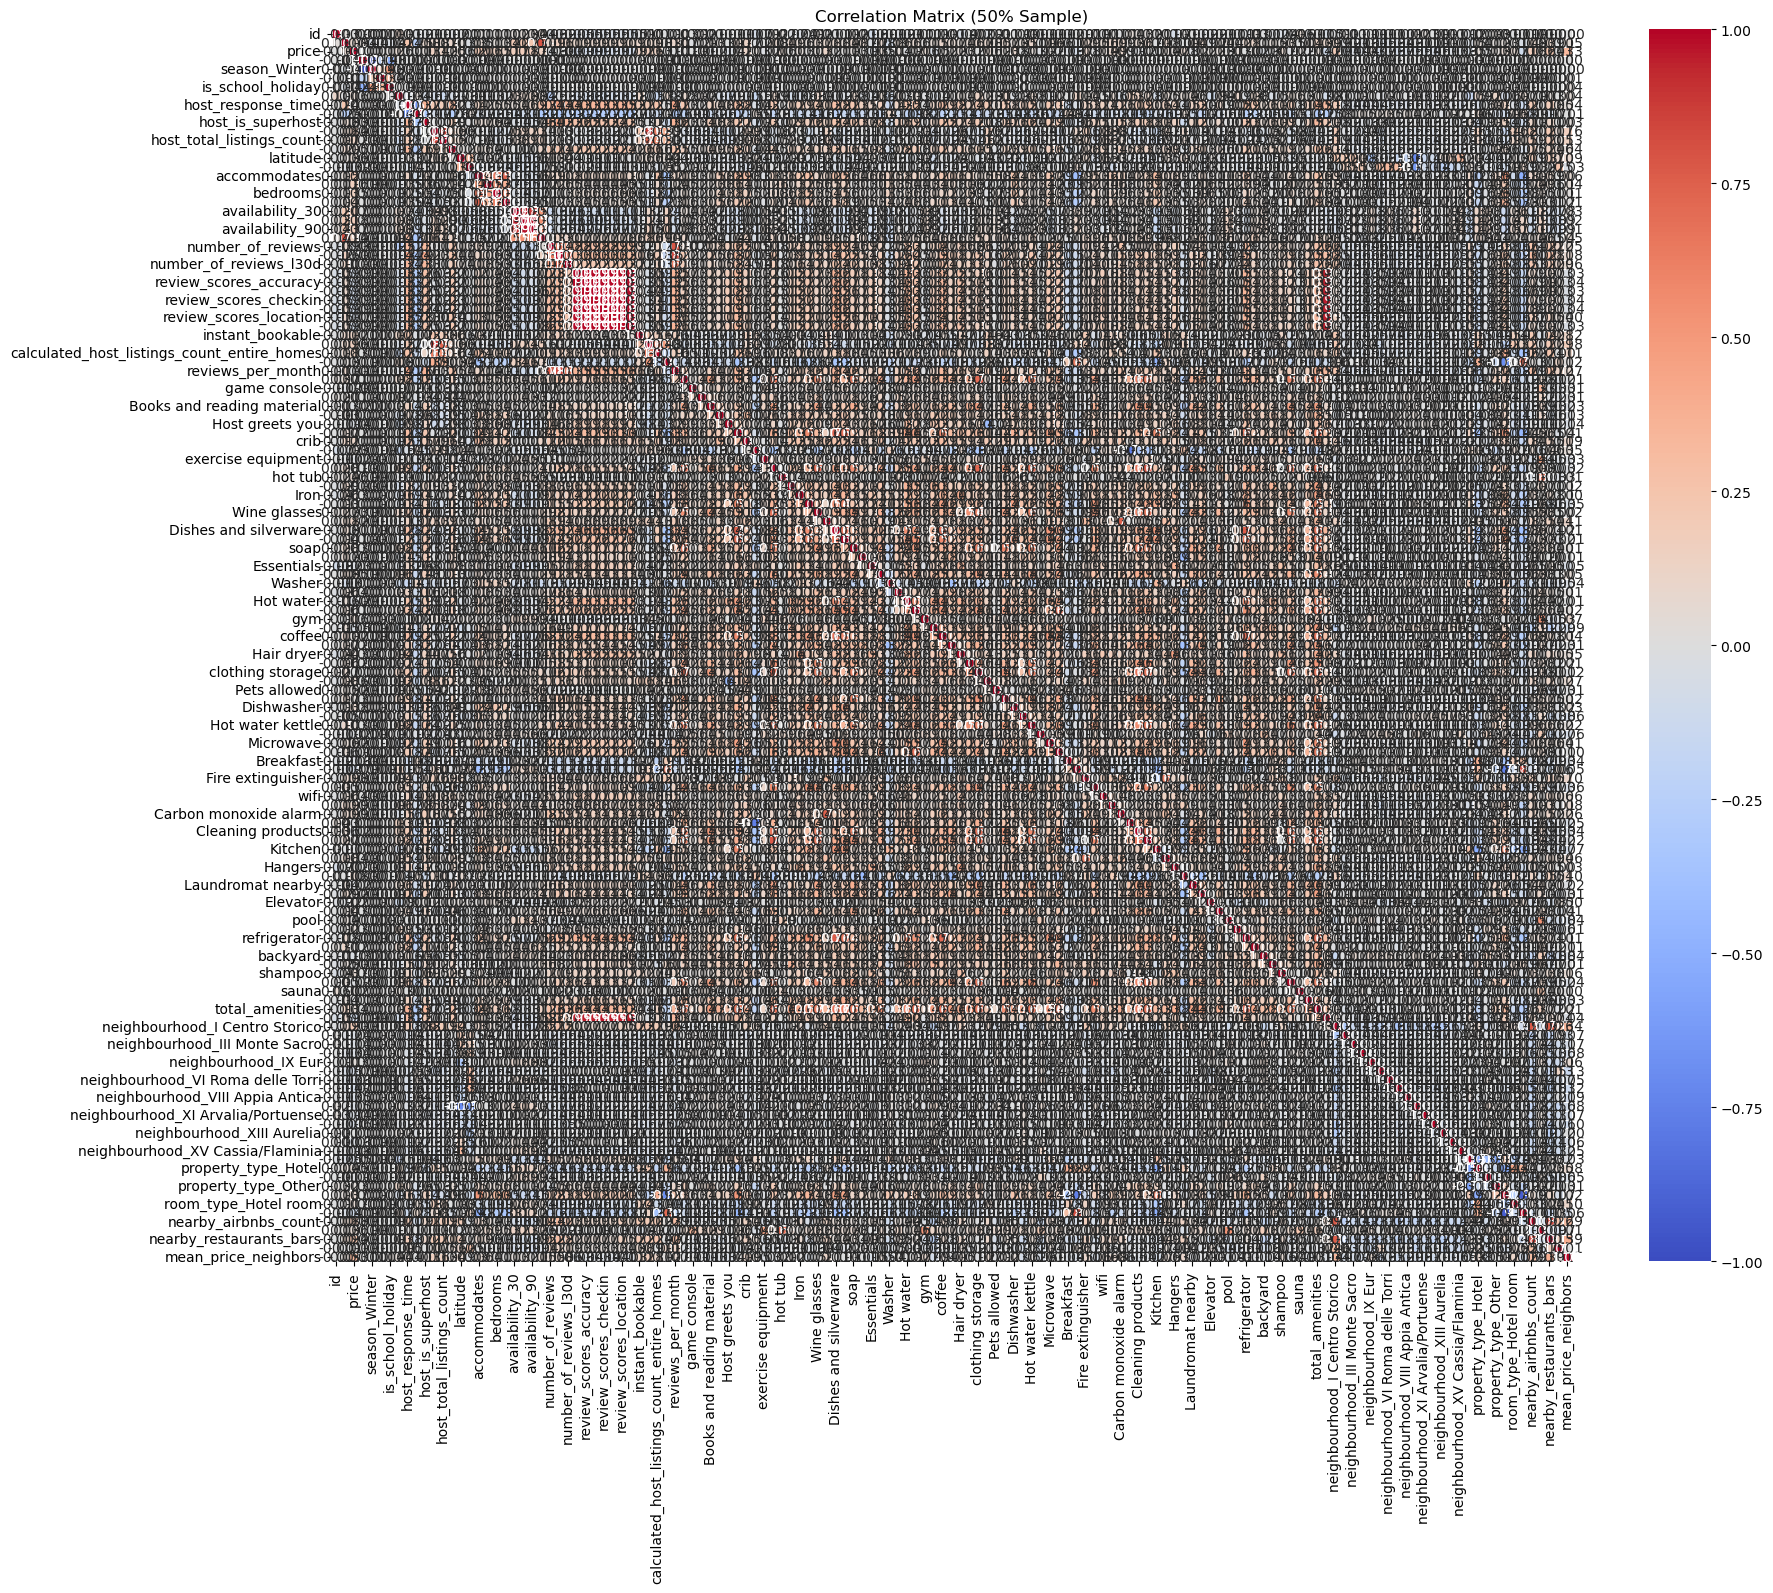

Creating heatmap: 100%|██████████ [Time: 00:24 < 00:00, 24.95s/it]

Time taken for heatmap visualization: 24.96 seconds
Total time taken: 37.61 seconds


In [63]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

# Convert the DataFrame to a Dask DataFrame
dask_df = dd.from_pandas(train_data_corrected, npartitions=10)

# Define the target column
target = 'price'

# Track the start time
start_time = time.time()

# Sample 50% of the data using Dask
print("Sampling data...")
sampled_dask_df = dask_df.sample(frac=0.50, random_state=1).compute()

# Convert the sampled data back to a Pandas DataFrame for correlation computation
sampled_data = pd.DataFrame(sampled_dask_df)

# Filter out non-numeric and boolean columns
numeric_data = sampled_data.select_dtypes(include=[float, int, bool]).copy()

# Temporarily convert boolean columns to integers for correlation computation
boolean_columns = numeric_data.select_dtypes(include=[bool]).columns
numeric_data[boolean_columns] = numeric_data[boolean_columns].astype(int)

# Check for constant columns and remove them
constant_columns = [col for col in numeric_data.columns if numeric_data[col].nunique() <= 1]
if constant_columns:
    print(f"Removing constant columns: {constant_columns}")
    numeric_data.drop(columns=constant_columns, inplace=True)

# Compute the correlation matrix for the numeric data
print("Computing correlation matrix...")
correlation_matrix = numeric_data.corr()

# Calculate correlations with the target column
correlations_with_target = correlation_matrix[target].dropna().sort_values(ascending=False)

# Display the correlations with the target column, sorted
print(f"\nCorrelations with {target}:")
for col, value in correlations_with_target.items():
    if col != target:
        print(f"{col}: {value:.2f}")

# Time taken for sampling and correlation computation
sampling_time = time.time() - start_time
print(f"Time taken for sampling and correlation computation: {sampling_time:.2f} seconds")

# Track time for heatmap visualization with tqdm progress
print("Visualizing heatmap...")
with tqdm(total=1, desc="Creating heatmap", bar_format="{l_bar}{bar} [Time: {elapsed} < {remaining}, {rate_fmt}{postfix}]") as pbar:
    visualization_start_time = time.time()
    
    # Visualize the correlations with a heatmap
    plt.figure(figsize=(20, 16))  # Adjust the size if needed
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix (50% Sample)')
    plt.show()
    
    # Update the progress bar
    pbar.update(1)

# Time taken for heatmap visualization
visualization_time = time.time() - visualization_start_time
print(f"Time taken for heatmap visualization: {visualization_time:.2f} seconds")

# Total time
total_time = time.time() - start_time
print(f"Total time taken: {total_time:.2f} seconds")

In [64]:
train_data_corrected["room_type_Shared room"].describe()

count     772602
unique         1
top        False
freq      772602
Name: room_type_Shared room, dtype: object

In [65]:
columns_to_drop =["room_type_Shared room","calculated_host_listings_count_shared_rooms"]
train_data_corrected = train_data_corrected.drop(columns_to_drop, axis=1)
valid_data_corrected = valid_data_corrected.drop(columns_to_drop, axis=1)
test_data_corrected = test_data_corrected.drop(columns_to_drop, axis=1)

In [66]:
import pandas as pd

# Assuming 'correlation_matrix' is already computed
# and 'target' is defined as 'price'

# Extract the correlation values for the target variable
correlation_with_target = correlation_matrix[target]

# Create a DataFrame to hold both absolute and actual values
correlation_df = pd.DataFrame({
    'Correlation': correlation_with_target,
    'Absolute Correlation': correlation_with_target.abs()
})

# Sort by absolute correlation values
sorted_correlation_df = correlation_df.sort_values(by='Absolute Correlation', ascending=False)

# Top 10 features most correlated with the target
top_10_features = sorted_correlation_df.iloc[1:11]  # Exclude the target itself

# Bottom 10 features least correlated with the target
bottom_10_features = sorted_correlation_df.iloc[-10:]

# Display the top 10 and bottom 10 features
print("Top 10 features most correlated with the target variable:")
print(top_10_features[['Correlation', 'Absolute Correlation']])

print("\nBottom 10 features least correlated with the target variable:")
print(bottom_10_features[['Correlation', 'Absolute Correlation']])

Top 10 features most correlated with the target variable:
                                Correlation  Absolute Correlation
mean_price_neighbors               0.327185              0.327185
nearby_restaurants_bars            0.236219              0.236219
neighbourhood_I Centro Storico     0.202978              0.202978
accommodates                       0.200395              0.200395
availability_60                    0.179385              0.179385
nearby_airbnbs_count               0.176160              0.176160
availability_30                    0.171138              0.171138
availability_90                    0.169649              0.169649
calculated_host_listings_count     0.160439              0.160439
bathrooms                          0.156686              0.156686

Bottom 10 features least correlated with the target variable:
                         Correlation  Absolute Correlation
oven                        0.002903              0.002903
id                         -0.00269

In [ ]:
import dask.dataframe as dd
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time

# Convert the DataFrame to a Dask DataFrame
dask_df = dd.from_pandas(train_data_corrected, npartitions=10)

# Track the start time
start_time = time.time()

# Sample 50% of the data using Dask
print("Sampling data...")
sampled_dask_df = dask_df.sample(frac=0.50, random_state=1).compute()

# Convert the sampled data back to a Pandas DataFrame
sampled_data = pd.DataFrame(sampled_dask_df)

# Filter out non-numeric and boolean columns
numeric_data = sampled_data.select_dtypes(include=[float, int, bool]).copy()

# Temporarily convert boolean columns to integers for VIF calculation
boolean_columns = numeric_data.select_dtypes(include=[bool]).columns
numeric_data[boolean_columns] = numeric_data[boolean_columns].astype(int)

# Check for constant columns and remove them
constant_columns = [col for col in numeric_data.columns if numeric_data[col].nunique() <= 1]
if constant_columns:
    print(f"Removing constant columns: {constant_columns}")
    numeric_data.drop(columns=constant_columns, inplace=True)

# Function to calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# Calculate VIF values
print("Calculating VIF values...")
vif_df = calculate_vif(numeric_data)

# Display the VIF values
print("\nVIF values:")
print(vif_df.sort_values(by="VIF", ascending=False))

# Time taken for sampling and VIF calculation
total_time = time.time() - start_time
print(f"Total time taken: {total_time:.2f} seconds")

In [ ]:
import pandas as pd

# Assuming vif_df is your DataFrame containing the VIF values

# Save the VIF values to a CSV file
vif_df.to_csv('vif_values.csv', index=False)

print("VIF values saved to 'vif_values.csv'")

In [67]:
import pandas as pd

# Read the VIF values from the CSV file
vif_df = pd.read_csv('vif_values.csv')

print("VIF values read from 'vif_values.csv':")
print(vif_df)

VIF values read from 'vif_values.csv':
                     feature       VIF
0                         id  1.044140
1                  available  2.629403
2                      price  1.164142
3              season_Autumn  0.859374
4              season_Winter  0.869562
..                       ...       ...
134     nearby_airbnbs_count  3.251789
135   luxury_amenities_score  1.011106
136  nearby_restaurants_bars  3.545702
137         nearby_transport  0.983601
138     mean_price_neighbors  1.125490

[139 rows x 2 columns]


In [68]:
# Assuming correlation_matrix and high_vif_df have been already calculated

# Filter VIF values above 5
high_vif_df = vif_df[vif_df["VIF"] > 5]

# Display the high VIF values
print("\nVIF values above 5:")
print(high_vif_df.sort_values(by="VIF", ascending=False))

# Find all pairs of features with a correlation higher than 0.8
high_corr_pairs = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display the pairs of features with high correlations
print("\nPairs of features with absolute correlation higher than 0.8:")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: correlation = {pair[2]:.2f}")



VIF values above 5:
Empty DataFrame
Columns: [feature, VIF]
Index: []

Pairs of features with absolute correlation higher than 0.8:
season_Autumn and season_Winter: correlation = -1.00
host_listings_count and host_total_listings_count: correlation = 0.86
host_listings_count and calculated_host_listings_count: correlation = 0.89
availability_30 and availability_60: correlation = 0.95
availability_30 and availability_90: correlation = 0.89
availability_60 and availability_90: correlation = 0.97
number_of_reviews_ltm and reviews_per_month: correlation = 0.83
review_scores_rating and review_scores_accuracy: correlation = 0.99
review_scores_rating and review_scores_cleanliness: correlation = 0.99
review_scores_rating and review_scores_checkin: correlation = 0.99
review_scores_rating and review_scores_communication: correlation = 0.99
review_scores_rating and review_scores_location: correlation = 0.98
review_scores_rating and review_scores_value: correlation = 0.99
review_scores_rating and 

In [69]:
#decided columns to drop based on the correlation and multivariate analysis
columns_to_drop =["review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication"
                 ,"review_scores_location","review_scores_value","availability_60","availability_30"
                 , "room_type_Entire home/apt",'season_Spring', 'season_Summer', 'season_Winter',"room_type_Hotel room",'host_response_rate']
train_data_corrected = train_data_corrected.drop(columns_to_drop, axis=1)
valid_data_corrected = valid_data_corrected.drop(columns_to_drop, axis=1)
test_data_corrected = test_data_corrected.drop(columns_to_drop, axis=1)

In [70]:
import pandas as pd

# Assuming train_data_corrected, valid_data_corrected, and test_data_corrected are your DataFrames

# Define the kitchen-related features to combine
kitchen_features = ['Dishes and silverware', 'refrigerator', 'Cooking basics']

# Create a new feature 'kitchen_amenities' as the sum of the kitchen-related features for train_data_corrected
train_data_corrected['kitchen_amenities'] = train_data_corrected[kitchen_features].sum(axis=1)
# Drop the original kitchen-related features for train_data_corrected
train_data_corrected = train_data_corrected.drop(columns=kitchen_features)

# Repeat the same for valid_data_corrected
valid_data_corrected['kitchen_amenities'] = valid_data_corrected[kitchen_features].sum(axis=1)
valid_data_corrected = valid_data_corrected.drop(columns=kitchen_features)

# Repeat the same for test_data_corrected
test_data_corrected['kitchen_amenities'] = test_data_corrected[kitchen_features].sum(axis=1)
test_data_corrected = test_data_corrected.drop(columns=kitchen_features)

# Display the first few rows and describe of the modified DataFrames to verify the changes
print("Train Data:")
print(train_data_corrected["kitchen_amenities"].describe())

print("\nValid Data:")
print(valid_data_corrected["kitchen_amenities"].describe())

print("\nTest Data:")
print(test_data_corrected["kitchen_amenities"].describe())

# Optionally, save the modified DataFrames to CSV files
# train_data_corrected.to_csv('train_data_corrected_with_kitchen_amenities.csv', index=False)
# valid_data_corrected.to_csv('valid_data_corrected_with_kitchen_amenities.csv', index=False)
# test_data_corrected.to_csv('test_data_corrected_with_kitchen_amenities.csv', index=False)

Train Data:
count    772602.000000
mean          2.000752
std           1.271087
min           0.000000
25%           1.000000
50%           3.000000
75%           3.000000
max           3.000000
Name: kitchen_amenities, dtype: float64

Valid Data:
count    85725.000000
mean         2.024322
std          1.263508
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: kitchen_amenities, dtype: float64

Test Data:
count    85755.000000
mean         2.036954
std          1.265471
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: kitchen_amenities, dtype: float64


In [ ]:
train_data_corrected.to_csv('train_data_corrected_with_kitchen_amenities.csv', index=False)
valid_data_corrected.to_csv('valid_data_corrected_with_kitchen_amenities.csv', index=False)
test_data_corrected.to_csv('test_data_corrected_with_kitchen_amenities.csv', index=False)

### Missing value check

In [71]:
import pandas as pd

# Assuming train_data_corrected, valid_data_corrected, and test_data_corrected are your DataFrames

# Function to check and print rows with missing values
def check_missing_values(df, df_name):
    rows_with_missing_values = df[df.isnull().any(axis=1)]
    
    print(f"Rows with missing values in {df_name}:")
    print(rows_with_missing_values)
    
    # Display the total number of rows with missing values
    print(f"Total number of rows with missing values in {df_name}: {rows_with_missing_values.shape[0]}")
    
    # Optionally, save these rows to a CSV file
    # rows_with_missing_values.to_csv(f'rows_with_missing_values_in_{df_name}.csv', index=False)

# Check for missing values in train_data_corrected
check_missing_values(train_data_corrected, "train_data_corrected")

# Check for missing values in valid_data_corrected
check_missing_values(valid_data_corrected, "valid_data_corrected")

# Check for missing values in test_data_corrected
check_missing_values(test_data_corrected, "test_data_corrected")

Rows with missing values in train_data_corrected:
Empty DataFrame
Columns: [id, date, available, price, season_Autumn, is_holiday, is_school_holiday, host_id, host_response_time, host_is_superhost, host_listings_count, host_total_listings_count, host_identity_verified, latitude, longitude, accommodates, bathrooms, bedrooms, beds, availability_90, availability_365, number_of_reviews, number_of_reviews_ltm, number_of_reviews_l30d, review_scores_rating, instant_bookable, calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, reviews_per_month, Bidet, game console, sound system, Books and reading material, toys children, Host greets you, crib, Heating, exercise equipment, Dining table, hot tub, Long term stays allowed, Iron, oven, Wine glasses, Smoke alarm, stove, soap, AC - split type ductless system, Essentials, Room-darkening shades, Washer, broadcast, Hot water, Bed linens, gym, parking, coffee, Free washer – In unit, 

# Saving the final datasets

In [72]:
import pandas as pd
#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Rome Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/train_data_corrected_with_kitchen_amenities.csv'
#read data, and quickly check if it is correctly read in
final_train_data= pd.read_csv(file_path)

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Rome Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/valid_data_corrected_with_kitchen_amenities.csv'
#read data, and quickly check if it is correctly read in
final_val_data= pd.read_csv(file_path)

#insert file_path for the data
file_path = 'C:/Users/anton/Documents/2de_master/Thesis/Code/analysis/Code/Airbnb_Spatiotemporal_Analysis/Rome Airbnb_Spatiotemporal_Analysis/Data Cleaning Listings/test_data_corrected_with_kitchen_amenities.csv'
#read data, and quickly check if it is correctly read in
final_test_data= pd.read_csv(file_path)

In [73]:
final_train_data.info()
final_val_data.info()
final_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772602 entries, 0 to 772601
Columns: 126 entries, id to kitchen_amenities
dtypes: bool(96), float64(10), int64(19), object(1)
memory usage: 247.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85725 entries, 0 to 85724
Columns: 126 entries, id to kitchen_amenities
dtypes: bool(96), float64(10), int64(19), object(1)
memory usage: 27.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85755 entries, 0 to 85754
Columns: 126 entries, id to kitchen_amenities
dtypes: bool(96), float64(10), int64(19), object(1)
memory usage: 27.5+ MB


In [ ]:
final_train_data.to_csv('FINAL_TRAIN_DATA_ROME.csv', index=False)
final_val_data.to_csv('FINAL_VALID_DATA_ROME.csv', index=False)
final_test_data.to_csv('FINAL_TEST_DATA_ROME.csv', index=False)